In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import sys
sys.path.append("../..")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo

from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = [12, 8]
c = ["#007fff", "#ff3616", "#138d75", "#7d3c98", "#fbea6a"]  # Blue, Red, Green, Purple, Yellow
set2 = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]  # Set2
sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=3.,
    palette=sns.color_palette("Set2")
)
CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 43
FONTSIZE = 48

In [2]:
blank_traces = np.load("./tunneling_conductances_pull.npz", allow_pickle=True)["arr_0"]
molecular_traces = np.load("./molecular_conductances_pull.npz", allow_pickle=True)["arr_0"]

In [ ]:
import scipy
from scipy.signal import filtfilt

# LOW, HIGH = -5, -.5
# BINS = 64
# BINS_2D = (16, 32)

def slight_preprocessing(traces):
    return_data, fullwindow = [], []
    b, a = scipy.signal.butter(3, 0.1)
    amount_discarded = 0
    longest = 0
    for t in tqdm(traces):
        t = np.log10(t)
        full = t[t < -.5]
        full = full[full > -5]
        t = t[t > LOW]
        t = t[t < HIGH]

        if len(t) < 32:
            amount_discarded += 1
            continue
        if len(t) > 8_000:
            amount_discarded += 1
            continue
        if len(t) > longest:
            longest = len(t)
        # t = filtfilt(b, a, t)

        return_data.append(t)
        fullwindow.append(full)
    print(f"Longest trace: {longest}")
    print(f"Amount discarded: {amount_discarded}")
    plt.show()
    return np.array(fullwindow), np.array(return_data)

def get_histograms(traces):
    hist = []
    hist_2d = []
    for t in tqdm(traces):
        h, _ = np.histogram(t, bins=BINS, range=(LOW, HIGH))
        H, *_ = np.histogram2d(t, np.arange(len(t)), bins=BINS_2D, range=[[LOW, HIGH], [0, 1024 + 1024]])
        hist.append(h)
        hist_2d.append(H.ravel())
    
    return np.array(hist), np.array(hist_2d)

def extra_features(traces):
    features = []
    for t in traces:
        length = len(t)
        mean = np.mean(t)
        median = np.median(t)
        std = np.std(t)

        x = np.arange(len(t))
        m1 = np.polyfit(x, t, deg=1)
        # rmsd = np.mean((t - np.polyval(m1, x))**2)

        m2 = np.polyfit(x, t, deg=2)
        # rmsd2 = np.mean((t - np.polyval(m2, x))**2)
        
        features.append([
            length,
            mean,
            median,
            std,
            # rmsd,
            # rmsd2,
            m1[1],
            *m2[2:],
        ])
    return np.array(features)

In [3]:
pre_info = PreprocessInfo(
    high=-0.5,
    low=-5,
    plot_high=-.5,
    plot_low=-5,
    bins=100,
    bins_2d=(32, 32),
    hist2d_length=1024,
)

In [4]:
p_blanks, fullwindow_blanks = util_functions.rt_preprocessing(
    blank_traces[::2], pre_info, longest_cutoff=6_000, apply_log=True
)
p_molecular, fullwindow_molecular = util_functions.rt_preprocessing(
    molecular_traces[::1], pre_info, longest_cutoff=6_000, apply_log=True
)

hist_blanks, hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)
hist_molecular, hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)

# plot_hist_blanks, plot_hist_blanks2d = util_functions.get_histograms(
#     fullwindow_blanks, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
# )
# plot_hist_molecular, plot_hist_molecular2d = util_functions.get_histograms(
#     fullwindow_molecular, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
# )

# ef_blanks = extra_features(p_blanks)
# ef_molecular = extra_features(p_molecular)

100%|██████████| 10150/10150 [00:04<00:00, 2196.41it/s]


Amount discarded: 363


100%|██████████| 20300/20300 [00:10<00:00, 1863.23it/s]


Amount discarded: 171


Generating 1D- and 2D histograms: 100%|██████████| 20129/20129 [00:08<00:00, 2374.71it/s]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


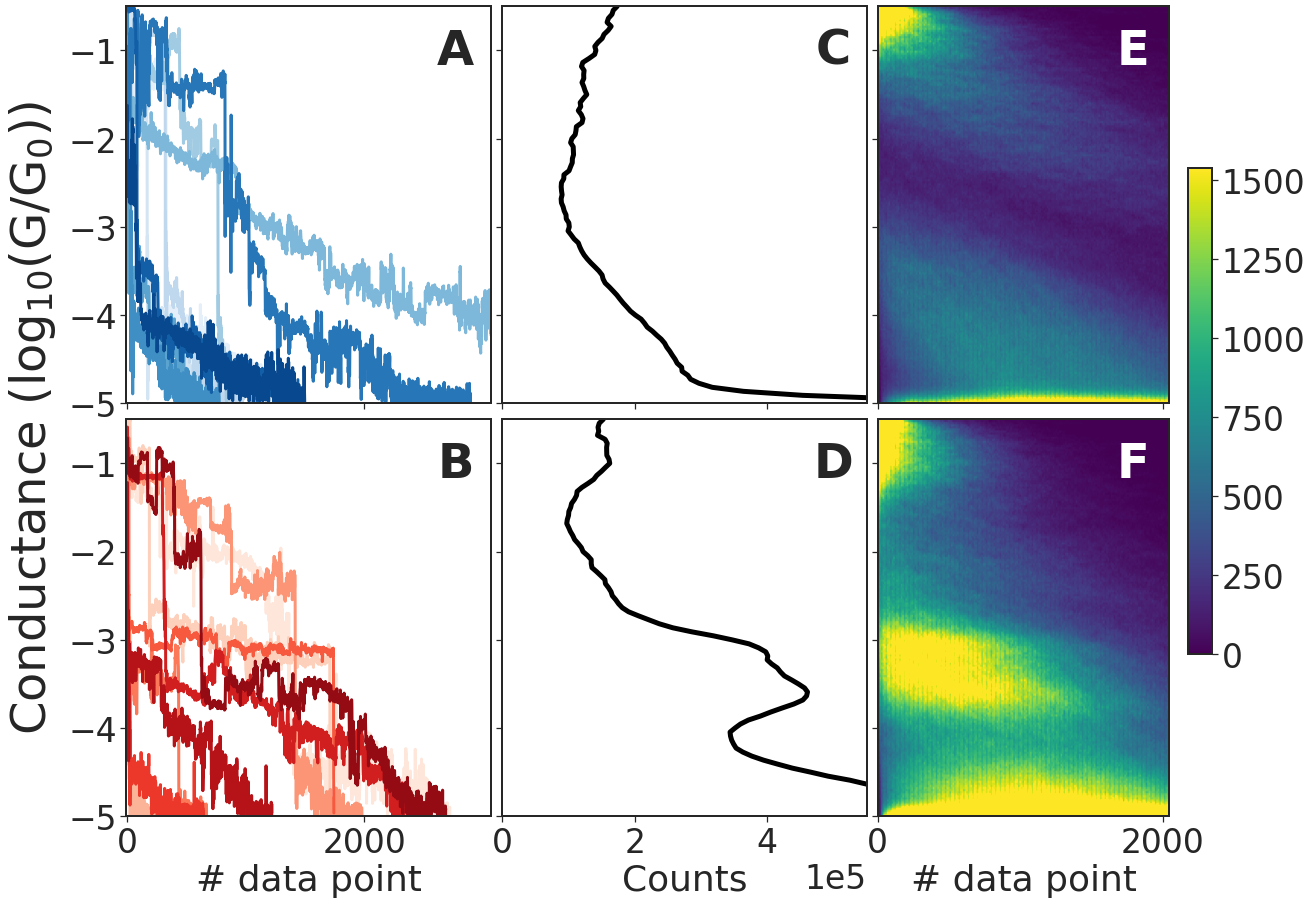

In [5]:
rng = np.random.default_rng(seed=RNG_STATE)
text_height = -1.
amount_traces = 10
blues = sns.color_palette("Blues", amount_traces)
reds = sns.color_palette("Reds", amount_traces)
colors = [blues, reds]

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [hist_blanks, fullwindow_blanks],
        [hist_molecular, fullwindow_molecular],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(low=0, high=len(dataset_traces), size=amount_traces, endpoint=True)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i], linewidth=3)
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, 2048 + 1024)
    ax[idx, 0].text(2048 + 1024 - 300, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    plot_hists = np.array(
        [np.histogram(trace, bins=pre_info.bins, range=(pre_info.plot_low, pre_info.plot_high))[0] for trace in dataset_traces]
    )
    ax[idx, 1].plot(
        plot_hists.sum(axis=0), np.linspace(pre_info.plot_low, pre_info.plot_high, plot_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 5.5e5)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(5e5, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in dataset_traces:
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, 2048]]
        )
        hist_2d += H

    im = ax[idx, 2].imshow(
        hist_2d, vmin=0, vmax=1024 + 512, origin="lower", cmap="viridis", extent=[0, 2048, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 2].text(
        2048 - 256, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )

    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.06, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.03, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("greta_hists.pdf")
plt.show()

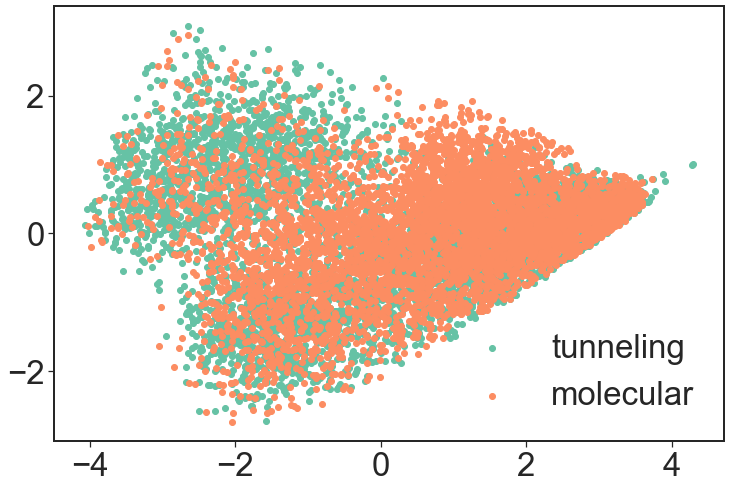

In [9]:
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
scaler = StandardScaler()
trans = pca.fit_transform(scaler.fit_transform(ef_blanks))
plt.scatter(trans[:, 0], trans[:, 1], label="tunneling")

trans = pca.transform(scaler.transform(ef_molecular))
plt.scatter(trans[:, 0], trans[:, 1], label="molecular")
plt.legend(frameon=False)
plt.show()

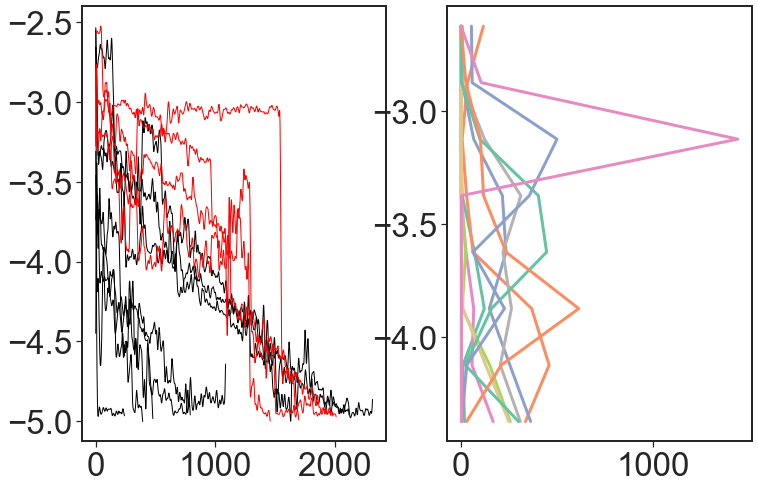

In [161]:
def plot_random_traces(traces, amount: int, ax, c):
    for trace in traces[np.random.choice(np.arange(len(traces)), size=amount)]:
        ax[0].plot(np.arange(len(trace)), trace, '-', linewidth=1, c=c)
        hist, binedges = np.histogram(trace, bins=BINS, range=(LOW, HIGH))
        binedges = (binedges[1:] + binedges[:-1])/2
        ax[1].plot(hist, binedges)
fig, ax = plt.subplots(1, 2)
plot_random_traces(p_blanks, amount=8, ax=ax, c="k")
plot_random_traces(p_molecular, amount=4, ax=ax, c="r")
plt.show()

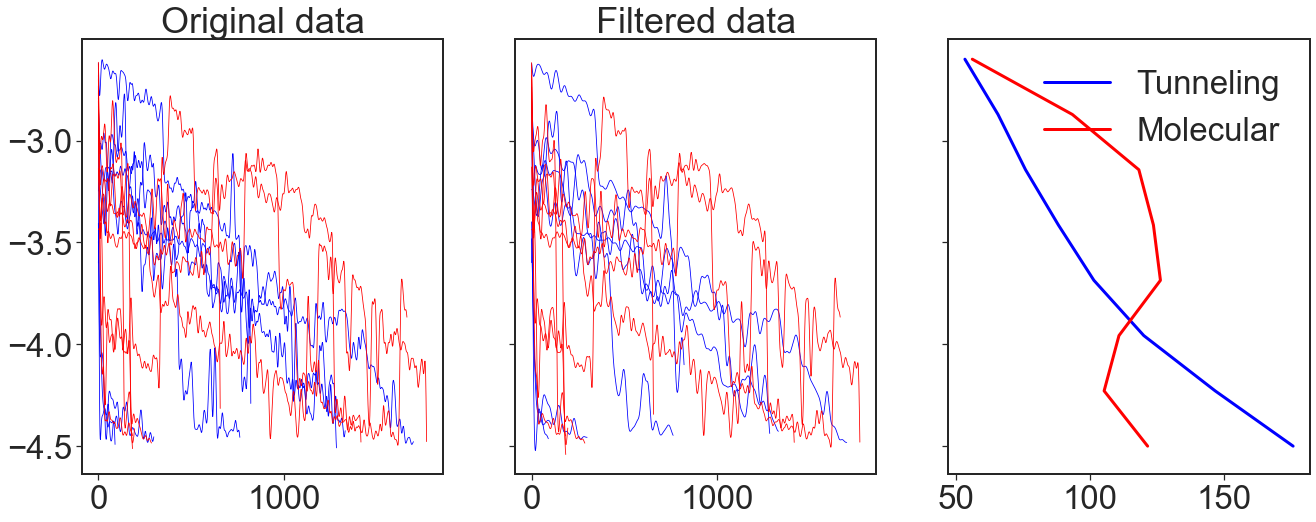

In [174]:
from scipy.signal import filtfilt
import scipy

linewidth = 0.8
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(22, 8))
size = 8
for t in p_blanks[np.random.randint(0, len(p_blanks), size=size)]:
    ax[0].plot(t, c="b", linewidth=linewidth)

    b, a = scipy.signal.butter(3, 0.05)
    filtered = filtfilt(b, a, t)
    ax[1].plot(filtered, c="b", linewidth=linewidth)
ax[0].set_title("Original data")
ax[1].set_title("Filtered data")

for t in p_molecular[np.random.randint(0, len(p_molecular), size=size)]:
    ax[0].plot(t, markersize=2, linewidth=linewidth, c="r")
    
    b, a = scipy.signal.butter(3, 0.1)
    filtered = filtfilt(b, a, t)
    ax[1].plot(filtered, c="r", linewidth=linewidth)

x = np.linspace(LOW, HIGH, BINS)
ax[2].plot(hist_blanks.sum(axis=0)/len(hist_blanks), x, c="b", label="Tunneling")
ax[2].plot(hist_molecular.sum(axis=0)/len(hist_molecular), x, c="r", label="Molecular")
ax[2].legend(frameon=False)
plt.show()

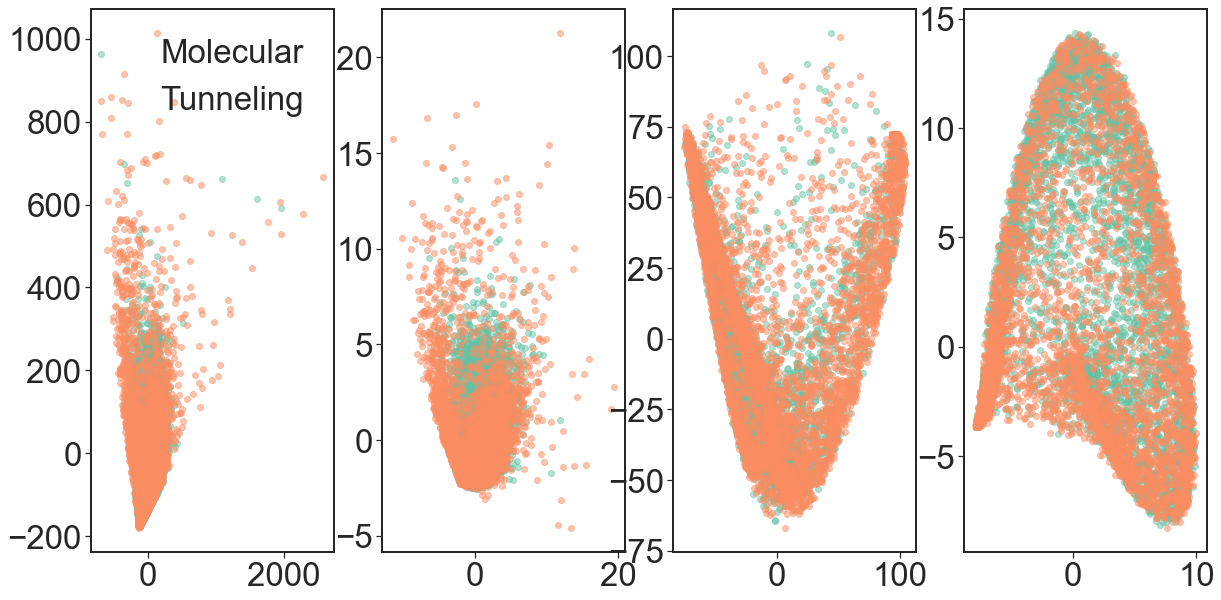

In [6]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=4)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
alpha = .5
for idx, features in enumerate([[hist_blanks, hist_molecular], [hist_blanks2d, hist_molecular2d]]):
    trans = pca.fit_transform(features[0])
    trans_mol = pca.transform(features[1])
    ax[idx*2].scatter(trans_mol[:, 0], trans_mol[:, 1], alpha=alpha, label="Molecular")
    ax[idx*2].scatter(trans[:, 0], trans[:, 1], alpha=alpha, label="Tunneling")

    scaler = StandardScaler()
    trans = pca.fit_transform(scaler.fit_transform(features[0]))
    trans_mol = pca.transform(scaler.transform(features[1]))
    ax[idx*2 + 1].scatter(trans_mol[:, 0], trans_mol[:, 1], alpha=alpha)
    ax[idx*2 + 1].scatter(trans[:, 0], trans[:, 1], alpha=alpha)
ax[0].legend(frameon=False)
plt.show()

/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learn

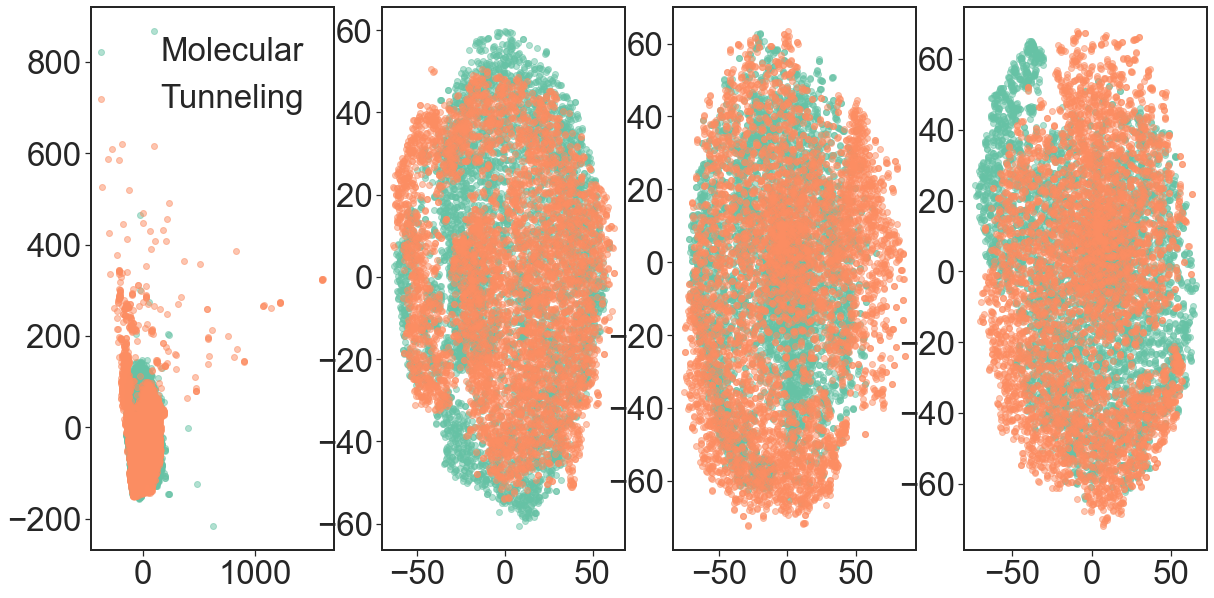

In [294]:
from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
tsne = TSNE(n_components=2, init="pca")

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
alpha = .5
for idx, features in enumerate([[hist_blanks, hist_molecular], [hist_blanks2d, hist_molecular2d]]):
    tsne_trans = tsne.fit_transform(features[0])
    tsne_trans_mol = tsne.fit_transform(features[1])
    ax[idx*2].scatter(tsne_trans_mol[:, 0], tsne_trans_mol[:, 1], alpha=alpha, label="Molecular")
    ax[idx*2].scatter(tsne_trans[:, 0], tsne_trans[:, 1], alpha=alpha, label="Tunneling")

    scaler = StandardScaler()
    tsne_trans = tsne.fit_transform(scaler.fit_transform(features[0]))
    tsne_trans_mol = tsne.fit_transform(scaler.transform(features[1]))
    ax[idx*2 + 1].scatter(tsne_trans_mol[:, 0], tsne_trans_mol[:, 1], alpha=alpha)
    ax[idx*2 + 1].scatter(tsne_trans[:, 0], tsne_trans[:, 1], alpha=alpha)
ax[0].legend(frameon=False)
plt.show()

In [6]:
# collapse molecular peak
# start, gap = 24, 6
# hist_blanks_smoothed = np.concatenate(
#     (
#         hist_blanks[:, :start], np.sum(hist_blanks[:, start:start + gap], axis=1)[:, None]/gap, hist_blanks[:, start + gap:]
#     ), axis=1
# )
# hist_molecular_smoothed = np.concatenate(
#     (
#         hist_molecular[:, :start], np.sum(hist_molecular[:, start:start + gap], axis=1)[:, None]/gap, hist_molecular[:, start + gap:]
#     ), axis=1
# )
# plt.plot(hist_molecular_smoothed.sum(axis=0))
# plt.plot(hist_molecular.sum(axis=0))
# plt.axvline(start, linestyle="--", c="k")
# plt.axvline(start + gap, linestyle="--", c="k")
# plt.show()

# features_blanks = hist_blanks
# features_molecular = hist_molecular

features_blanks = hist_blanks2d
features_molecular = hist_molecular2d

# easy cleaning
# quick_labels = [1 if np.median(x) < -4.1 else -1 for x in p_blanks]
# feature_blanks = features_blanks[quick_labels == -1]
# features_blanks[features_blanks == 0] = 1e-4
# features_molecular[features_molecular == 0] = 1e-4
# the DL models can't handle 0's in the features due to sigmoid activation function

# features_blanks = np.concatenate((hist_blanks2d, ef_blanks), axis=1)
# features_molecular = np.concatenate((hist_molecular2d, ef_molecular), axis=1)
# features_blanks = ef_blanks
# features_molecular = ef_molecular


# remove zero columns
# idx = np.argwhere(np.all(features_blanks[..., :] < 6, axis=0))

# a2 = np.delete(features_blanks, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_blanks)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")

# features_blanks = a2

# a2 = np.delete(features_molecular, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_molecular)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")
# features_molecular = a2

In [7]:
from sklearn.svm import OneClassSVM
# from sklearn.ensemble import IsolationForest
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE
from sklearn.metrics import pairwise
from functools import partial
laplacian = partial(pairwise.laplacian_kernel, gamma=0.02)

# model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.014)
model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale")
# model_ocsvm_laplac = OneClassSVM(kernel=laplacian, nu=0.01)
model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01)
# model_iso = IsolationForest(contamination=0.001)
# model_gmm_1comp = GMMOutlierDetector(n_components=1, threshold=0.99, random_state=RNG_STATE)
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)
model_gmm_9comp = GMMOutlierDetector(n_components=9, threshold=0.99, random_state=RNG_STATE)
model_gmm_12comp = GMMOutlierDetector(n_components=12, threshold=0.99, random_state=RNG_STATE)
model_gmm_20comp = GMMOutlierDetector(n_components=20, threshold=0.99, random_state=RNG_STATE)

# deep learning models
# epochs = 24
# contamination = 0.01
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=contamination, random_state=RNG_STATE)
# model_deepsvdd_ae = DeepSVDD(
#     use_ae=True,
#     epochs=epochs,
#     # hidden_neurons=[512, 512, 256],
#     hidden_activation="relu",
#     contamination=contamination,
#     optimizer="adam",
#     random_state=RNG_STATE,
# )
# model_deepsvdd_noae = DeepSVDD(
#     use_ae=False,
#     epochs=epochs,
#     # hidden_neurons=[512, 512, 256],
#     hidden_activation="relu",
#     contamination=contamination,
#     random_state=RNG_STATE,
# )
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=contamination, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    # model_ocsvm_laplac,
    # # model_iso,  
    # model_gmm_1comp,
    model_gmm_3comp,
    # model_gmm_5comp,
    model_gmm_9comp,
    model_gmm_12comp,
    model_gmm_20comp,
    # model_simple_ae,
    # model_deepsvdd_ae,
    # model_deepsvdd_noae,
    # model_vae,
]

In [162]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scaler = MinMaxScaler(feature_range=(1e-4, 1))
scaler = StandardScaler()
scaled_blanks = scaler.fit_transform(features_blanks)
scaled_molecular = scaler.transform(features_molecular)
predicted_labels = []
for model in tqdm(models):
    tmp_pca = PCA(n_components=256)
    model = model.fit(tmp_pca.fit_transform(scaled_blanks))

    # scaled = features_molecular
    pred_labels = model.predict(tmp_pca.transform(scaled_molecular))
    predicted_labels.append(pred_labels)

100%|██████████| 5/5 [01:21<00:00, 16.31s/it]


In [8]:
predicted_labels = np.load("./traditional_oc_labels_halftunneling.npy")

(1024, 512)


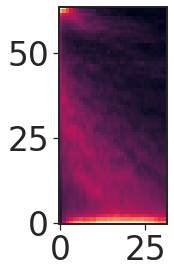

In [163]:
n_samples = 1024
sampled = models[-1].sample(n_samples=n_samples)
print(sampled[0].shape)

plt.imshow(scaler.inverse_transform(tmp_pca.inverse_transform(sampled[0])).reshape((n_samples, 64, 32)).sum(axis=0), origin="lower", vmin=0, vmax=n_samples*2)
plt.show()

# plt.plot(scaler.inverse_transform(sampled[0]).sum(axis=0)/n_samples)
# plt.plot(features_blanks.sum(axis=0)/len(features_blanks))

Amount predicted tunneling: 6451


Generating 2D histograms: 100%|██████████| 6451/6451 [00:02<00:00, 2421.77it/s]


Amount predicted tunneling: 6527


Generating 2D histograms: 100%|██████████| 6527/6527 [00:01<00:00, 3263.62it/s]


Amount predicted tunneling: 17140


Generating 2D histograms: 100%|██████████| 17140/17140 [00:05<00:00, 2938.05it/s]


Amount predicted tunneling: 7040


Generating 2D histograms: 100%|██████████| 7040/7040 [00:02<00:00, 3027.70it/s]


Amount predicted tunneling: 5892


Generating 2D histograms: 100%|██████████| 5892/5892 [00:01<00:00, 3060.36it/s]


Amount predicted tunneling: 5727


Generating 2D histograms: 100%|██████████| 5727/5727 [00:01<00:00, 3190.79it/s]


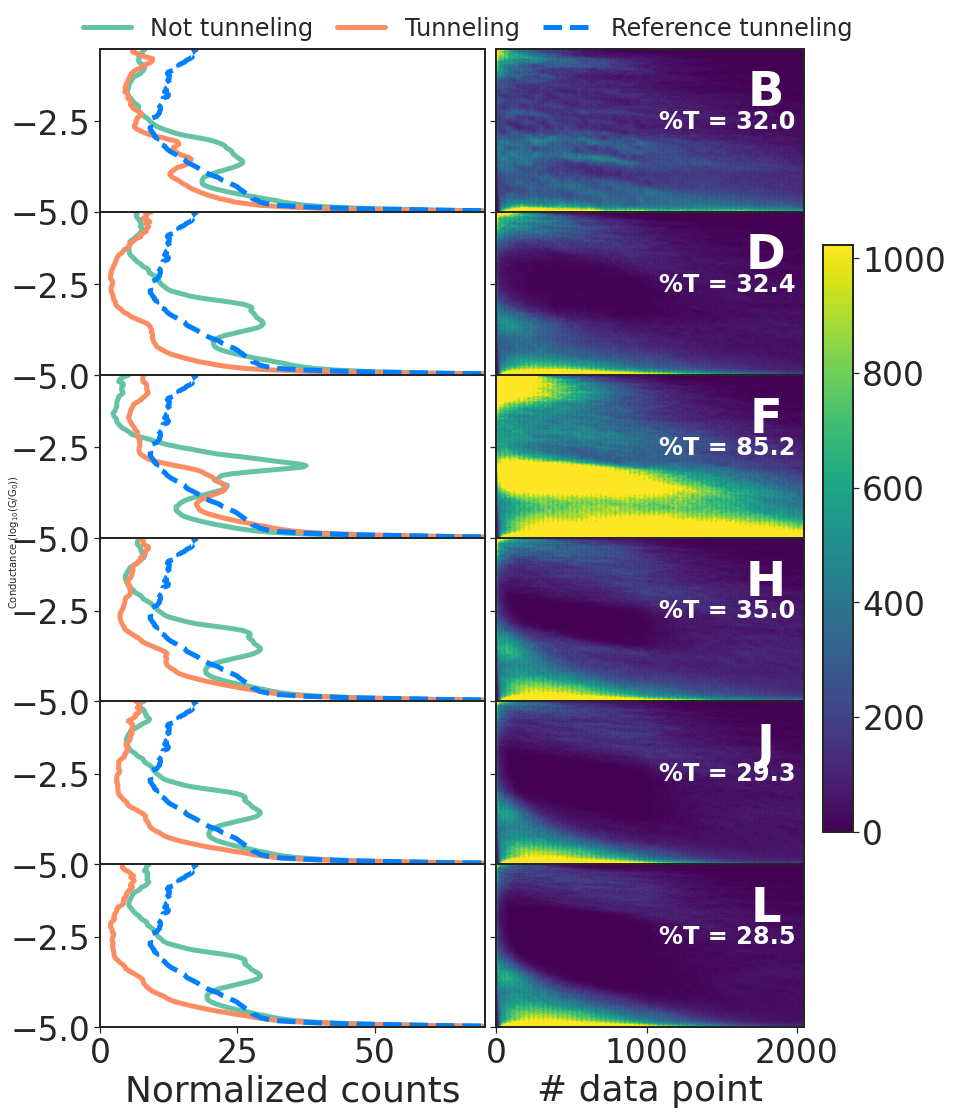

In [11]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26

ax1_yaxis = np.linspace(pre_info.low, pre_info.high, pre_info.bins)
# ax1_yaxis = np.concatenate(
#     (
#         ax1_yaxis[:start], [np.sum(ax1_yaxis[start:start + gap])/gap], ax1_yaxis[start + gap:]
#     )
# )
max_ax1 = 0
percentages = []
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        # pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    pred_tun = hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    print(f"Amount predicted blanks: {len(pred_tun)}")
    percentages.append(1.0 - (len(hist_molecular) - len(pred_tun))/len(hist_molecular))

    ax[idx, 0].plot(
        hist_blanks.sum(axis=0)/len(hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "_",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.low, pre_info.high], [0, 2048]]
        )
        hist_2d += H

    im = ax[idx, 1].imshow(
        hist_2d,
        vmin=0,
        vmax=1024,
        origin="lower",
        cmap="viridis",
        extent=[0, 2048, pre_info.low, pre_info.high],
        aspect="auto",
    )

    if np.max(pred_mol.sum(axis=0)/len(pred_mol)) > max_ax1:
        max_ax1 = np.max(pred_mol.sum(axis=0)/len(pred_mol))
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.low, pre_info.high)

text_height = -1.7
for idx, p in enumerate(percentages):
    ax[idx, 0].text(max_ax1 - max_ax1*0.0, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(
        1024 + 512 + 256, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    ax[idx, 1].text(1024 + 512, text_height - .9, f"%T = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")

    ax[idx, 0].set_xlim(0, max_ax1 + max_ax1*0.15)
    ax[idx, 0].set_xlim(0, 70)
    if idx == 0:
        ax[idx, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(-0.1, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE // 2)

ax[-1, 0].set_xlabel("Counts per trace")
ax[-1, 1].set_xlabel("# data point")
fig.text(0.04, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical")
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./greta_visual_perf.pdf")
plt.show()

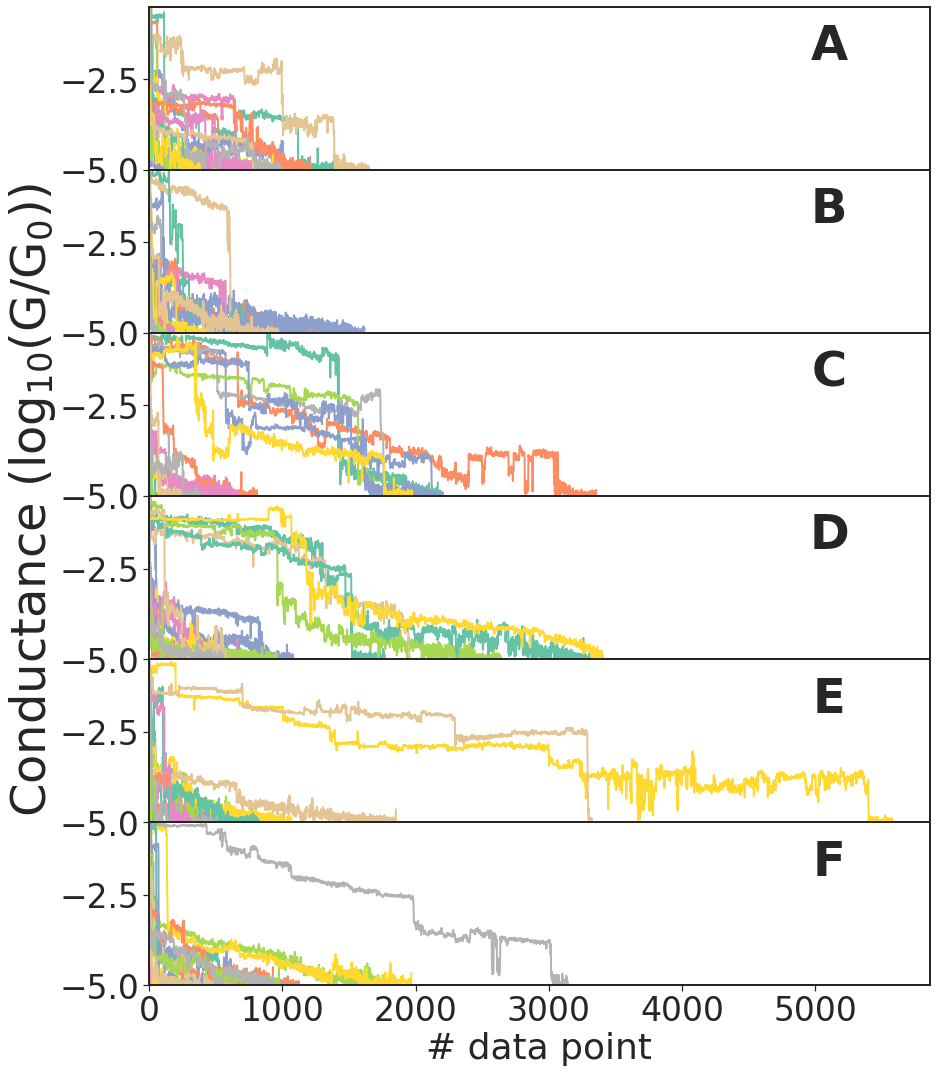

In [18]:
import matplotlib.cm as cmx
import matplotlib
cm_blues = plt.get_cmap("Blues")
cm_reds = plt.get_cmap("Reds")

bins_2d = 64
x, y = np.meshgrid(np.arange(0, bins_2d), np.arange(0, bins_2d))
fig, axes = plt.subplots(len(models), 1, figsize=(14, 18), sharex=True, sharey=True)
for idx, (ax, label_set) in enumerate(zip(axes, predicted_labels)):
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_blues)
    # hist_2d = generate_2dhistograms(fullwindow_molecular[label_set == 1], bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=5, alpha=.5)
    
    # hist_2d = generate_2dhistograms(fullwindow_blanks, bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_reds)
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=2)

    util_functions.plot_individual_traces(p_molecular[label_set == 1], ax, size=16, rng=rng, lw=2)
    fig.text(0.8, .85 - idx*.126, ALPHABET[idx], weight="bold", size=FONTSIZE, va="center", ha="center")

plt.subplots_adjust(hspace=0.0)
plt.xlim(-4)
plt.ylim(pre_info.plot_low, pre_info.plot_high)
axes[-1].set_xlabel("# data point")
fig.text(0.01, 0.5, CONDUCTANCE_LABEL, ha="center", va="center", rotation="vertical", fontsize=FONTSIZE)
plt.savefig("predicted_tunneling_visualized.pdf")
plt.show()

In [25]:
def summary_statistics(traces: np.ndarray) -> np.ndarray:
    features = []
    for t in tqdm(traces):
        length = len(t)
        mean = np.mean(t)
        median = np.median(t)
        std = np.std(t)

        x = np.arange(len(t))
        m1 = np.polyfit(x, t, deg=1)

        # m2 = np.polyfit(x, t, deg=2)
        
        features.append([
            # length,
            mean,
            median,
            std,
            # *m1,
        ])
    return np.array(features)

100%|██████████| 13678/13678 [00:03<00:00, 3474.89it/s]


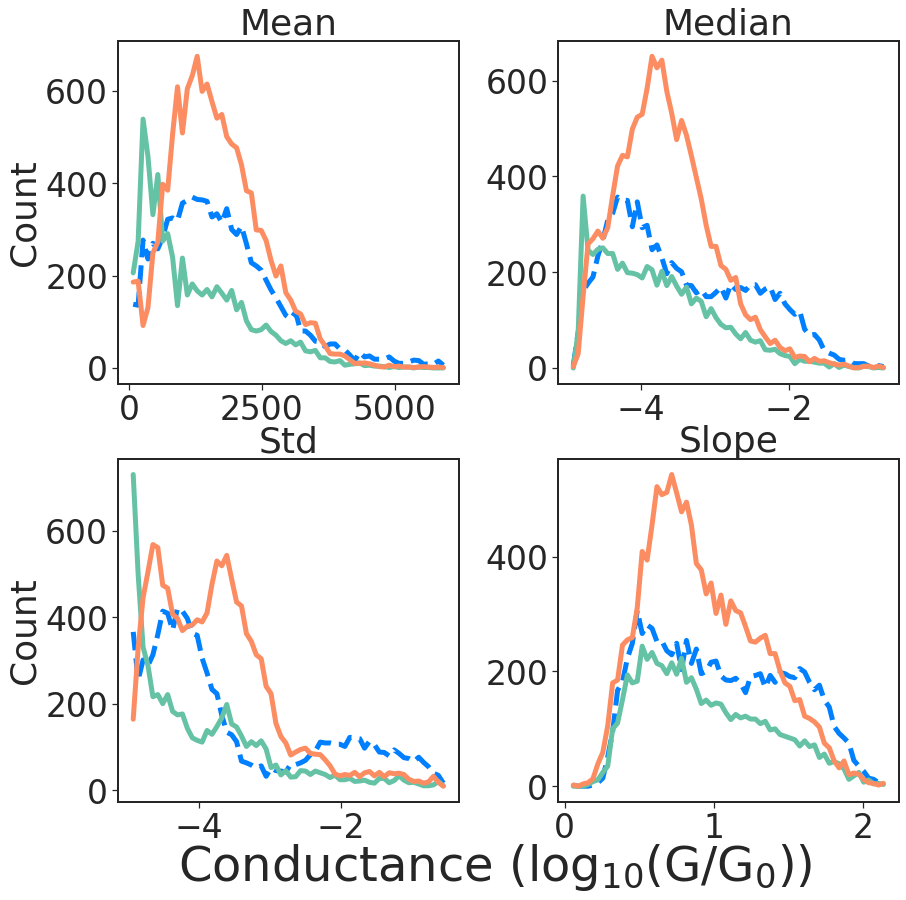

100%|██████████| 13602/13602 [00:04<00:00, 3152.70it/s]


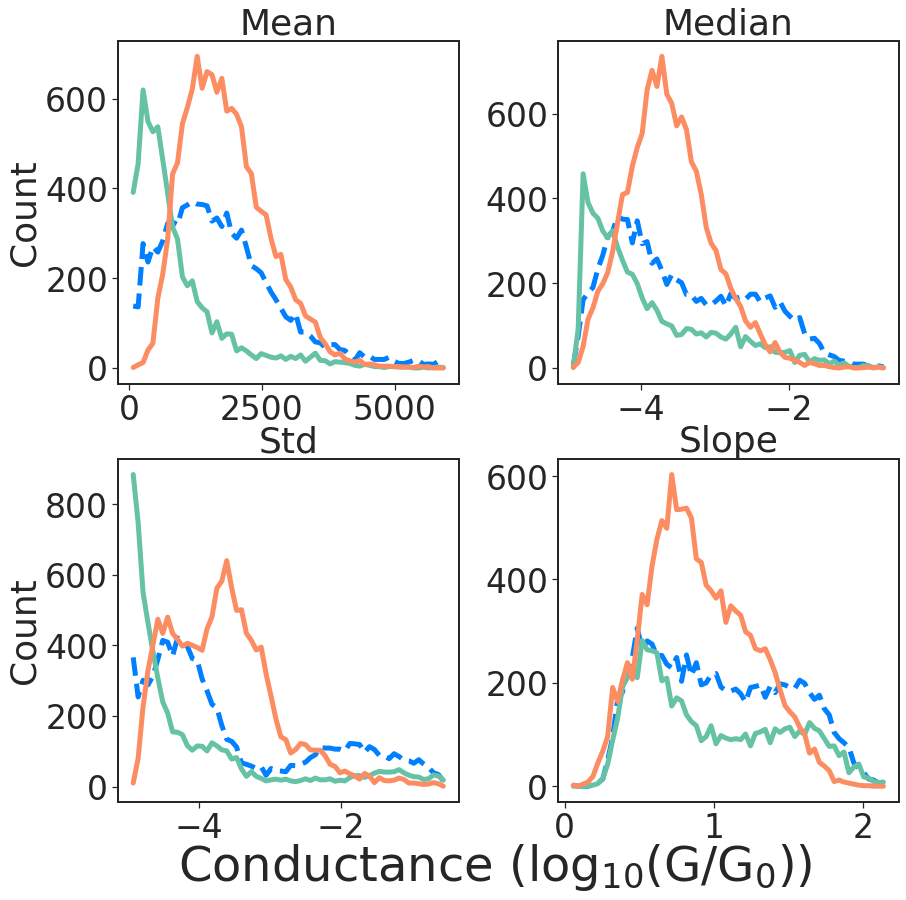

100%|██████████| 2989/2989 [00:00<00:00, 3353.08it/s]


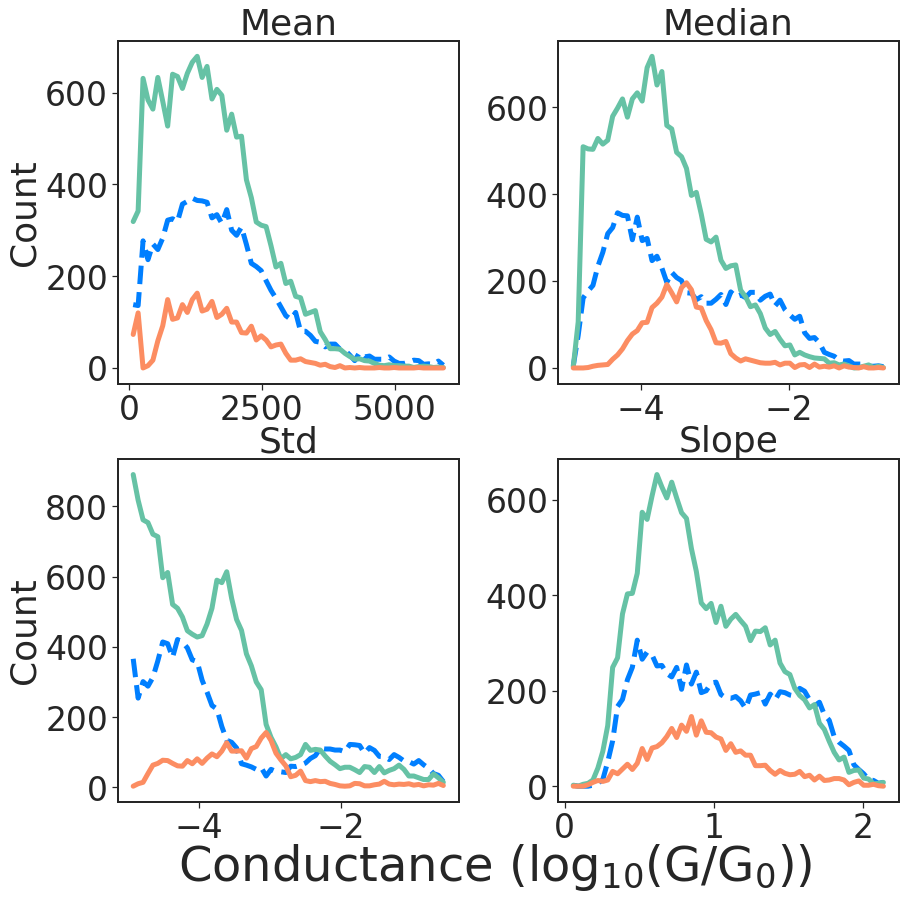

100%|██████████| 13089/13089 [00:03<00:00, 3435.11it/s]


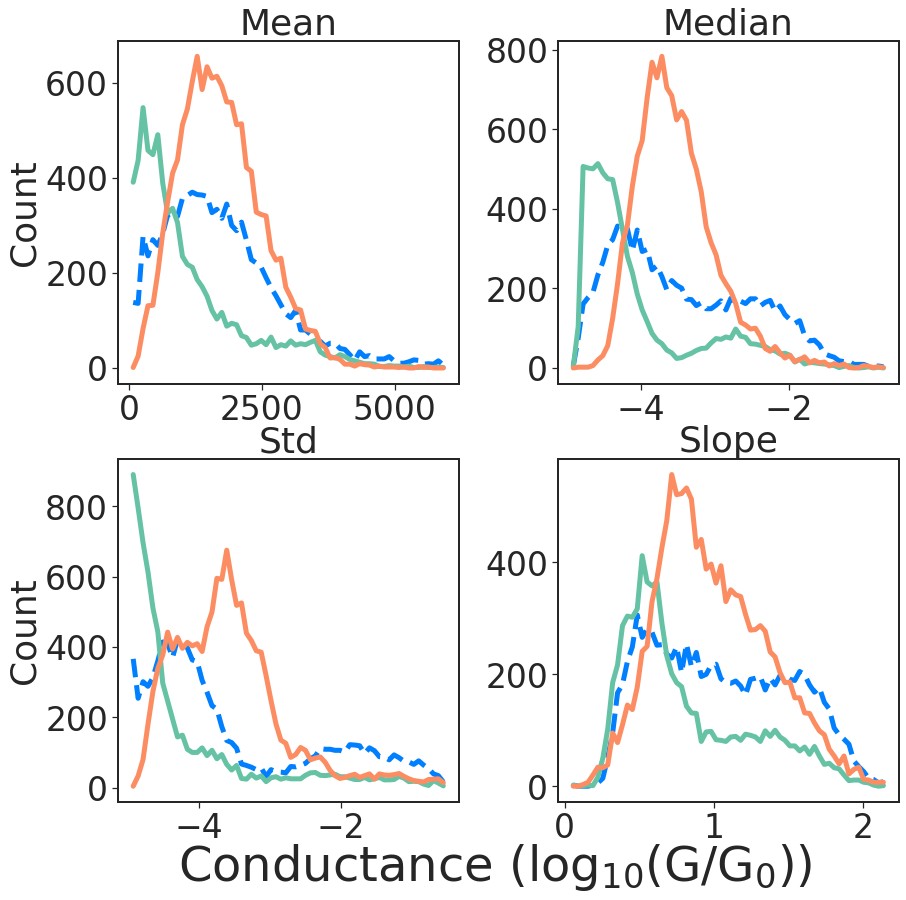

100%|██████████| 14237/14237 [00:04<00:00, 3254.43it/s]


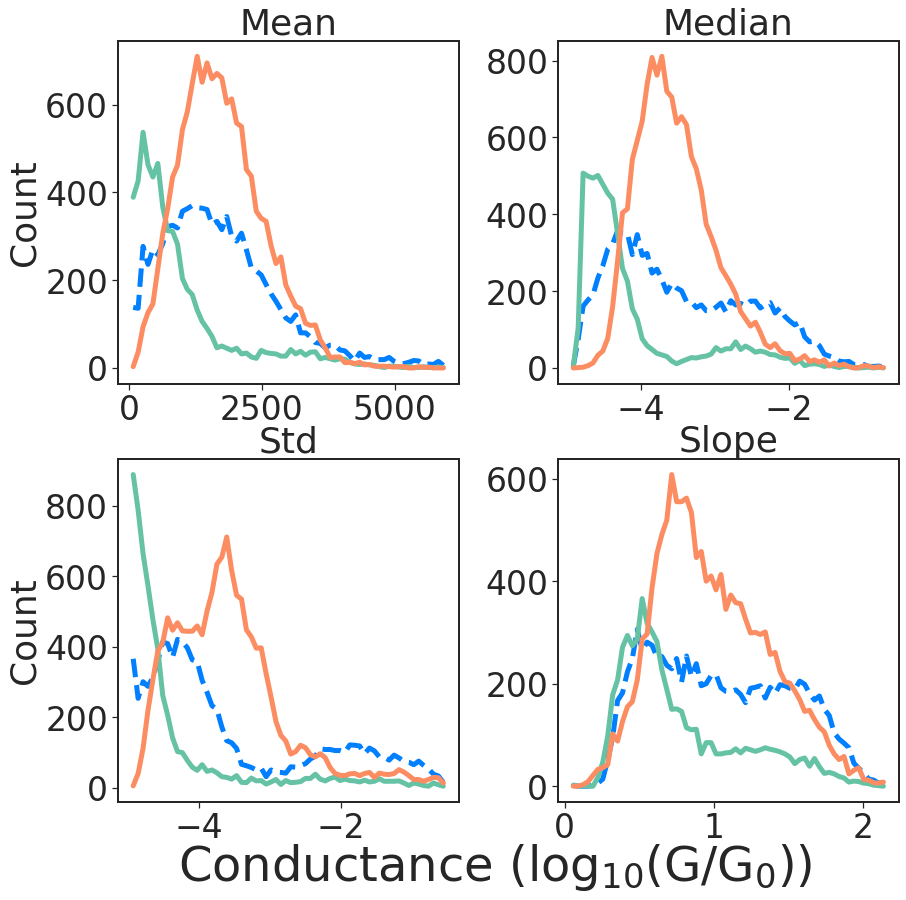

100%|██████████| 14402/14402 [00:04<00:00, 3400.11it/s]


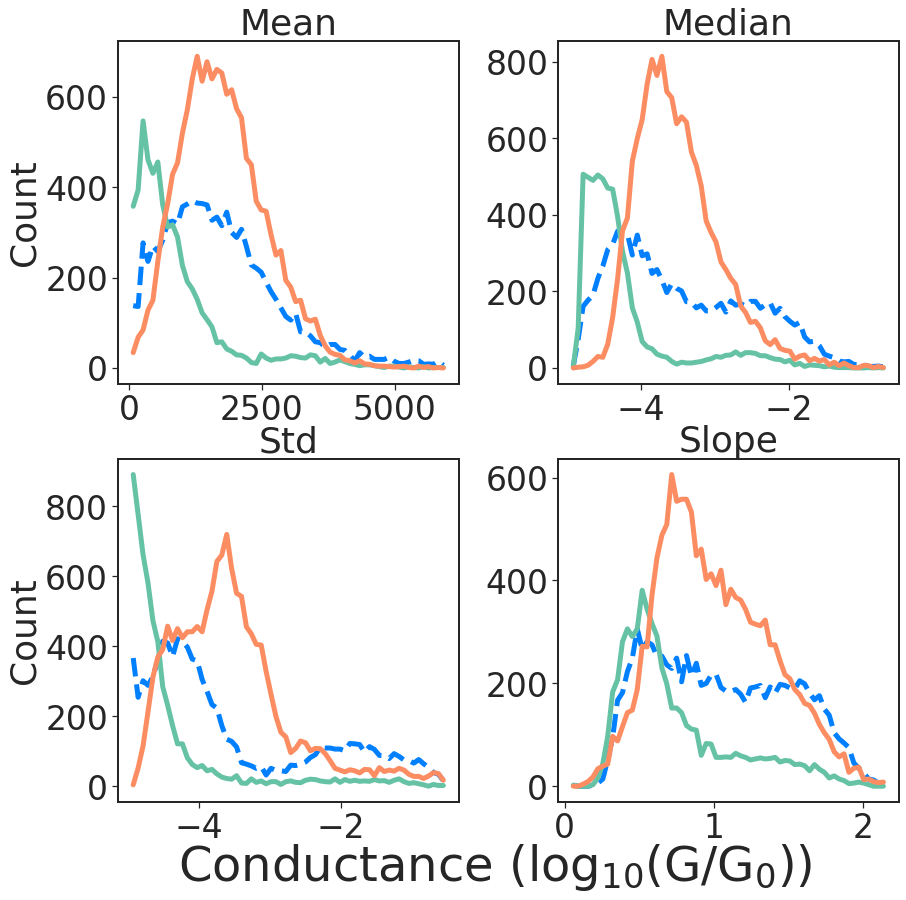

In [48]:
titles = [
    # "Length",
    "Mean",
    "Median",
    "Std",
    # "Offset",
    "Slope",
]
summary_blanks = summary_statistics(p_blanks)
for j, label_set in enumerate(predicted_labels):
    summary_pred_blanks = summary_statistics(p_molecular[label_set == 1])
    summary_pred_not = summary_statistics(p_molecular[label_set == -1])
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.ravel()
    for i, title in enumerate(titles):
        min_range = np.min(summary_blanks[:, i])
        max_range = np.max(summary_blanks[:, i])
        hist, binedges = np.histogram(summary_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Ref. blanks", linestyle="--", c=c[0])

        hist, binedges = np.histogram(summary_pred_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. blanks")

        hist, binedges = np.histogram(summary_pred_not[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. not-blanks")


        fs = 36
        if i % 2 == 0:
            axes[i].set_ylabel("Count", fontsize=fs)

        axes[i].set_title(title)
    fig.text(0.5, 0.06, CONDUCTANCE_LABEL, ha="center", va="center", fontsize=FONTSIZE)
    plt.subplots_adjust(hspace=.22, wspace=0.29)
    plt.savefig(f"summary_statistics_{j}")
    plt.show()

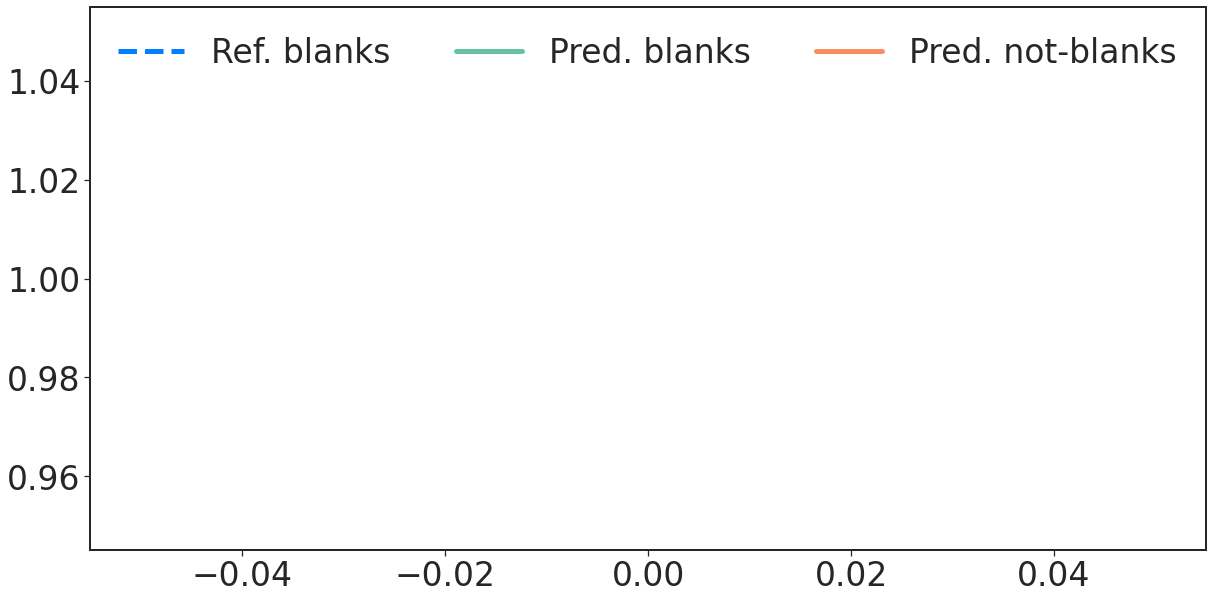

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(0, 1, label="Ref. blanks", c=c[0], linestyle="--")
plt.plot(0, 1, label="Pred. blanks")
plt.plot(0, 1, label="Pred. not-blanks")
plt.legend(frameon=False, ncol=3)
plt.savefig("legend.png")
plt.show()

In [86]:
simple_labels = np.array([1 if np.median(x) < -4.1 else -1 for x in p_molecular])

In [50]:
scaled = scaler.transform(features_molecular)
# scaled = features_molecular
subset = 3
pred_labels = models[-3].predict(scaled[::subset])

In [39]:
used_labels = pred_labels
if np.any(used_labels == 0):
    pred_labels[pred_labels == 0] = -1
    pred_labels *= -1

## Testing impact on further analysis

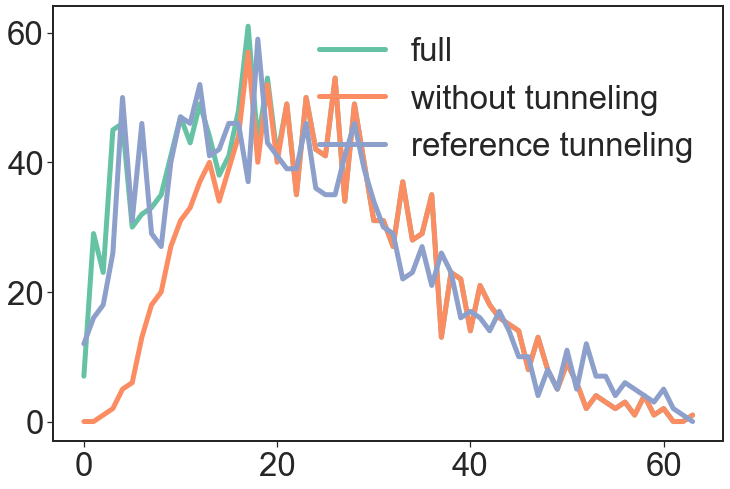

In [41]:
full_length = [len(x) for x in p_molecular[::subset]]
without_tunneling = [len(x) for x in p_molecular[::subset][used_labels == -1]]
ref_tunneling = [len(x) for x in p_blanks[::subset]]

bins = 64
plot_range = (0, 1024*4)
plt.plot(np.histogram(full_length, bins=bins, range=plot_range)[0], label="full")
plt.plot(np.histogram(without_tunneling, bins=bins, range=plot_range)[0], label="without tunneling")
plt.plot(np.histogram(ref_tunneling, bins=bins, range=plot_range)[0], label="reference tunneling")

plt.legend(frameon=False)
plt.show()

In [42]:
longest = 0
for t in p_molecular:
    if len(t) > longest:
        longest = len(t)
print(longest)

5622


In [51]:
# 5622 is the longest worked trace
mea_28x28 = np.array([np.histogram2d(trace, np.arange(len(trace)), bins=28, range=[[pre_info.low, pre_info.high], [0, 5622]])[0].ravel() for trace in p_molecular[::subset]])

In [45]:
mixed_mea = np.concatenate((hist_molecular[::subset], mea_28x28), axis=1)

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, metric="cosine", init="pca", learning_rate=200)
tsne_trans = tsne.fit_transform(mea_28x28)

/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


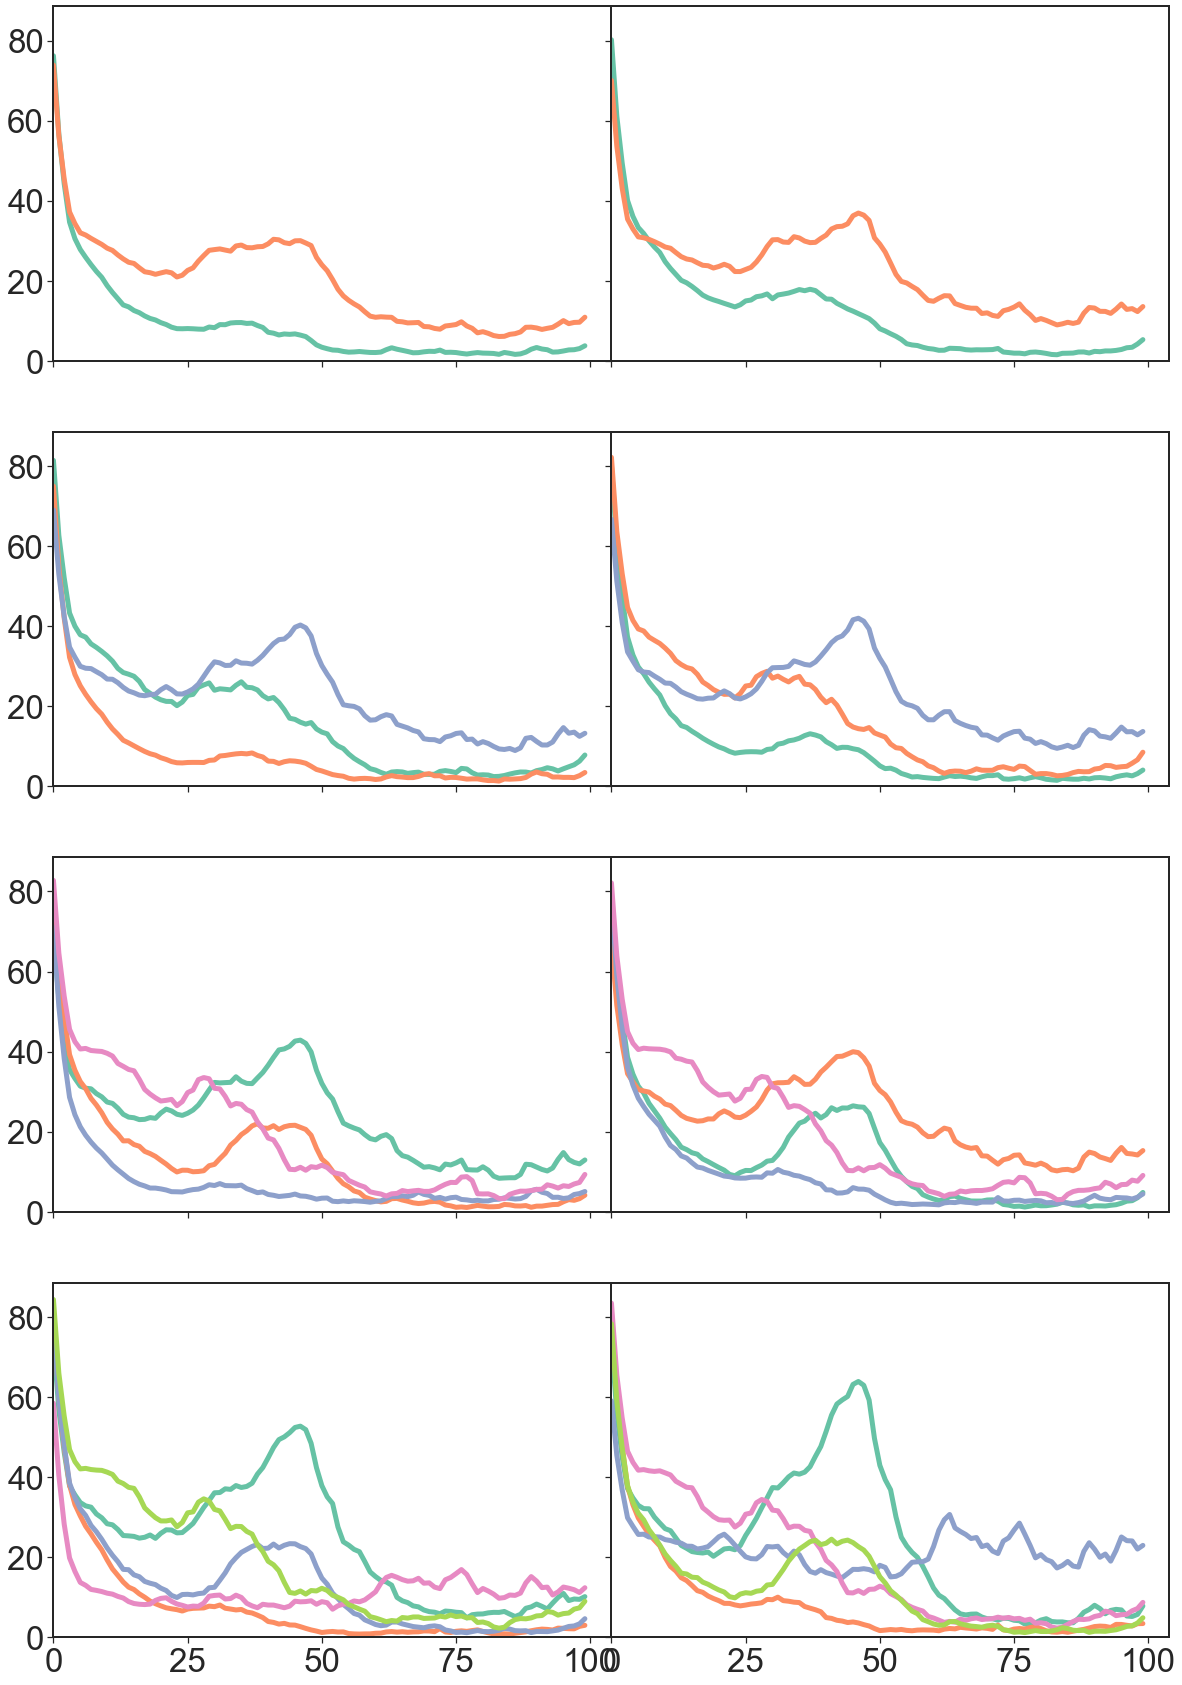

In [53]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

n_clusters = 5
fig, axes = plt.subplots(n_clusters - 2 + 1, 2, sharex=True, sharey=True, figsize=(20, 30))
fig.subplots_adjust(wspace=0.0)

for idx, i in enumerate(range(2, n_clusters + 1)):
    # cluster = GaussianMixture(n_components=i, verbose=1)
    cluster = KMeans(n_clusters=i)
    full_cluster_labels = cluster.fit_predict(tsne_trans)
    subset_cluster_labels = cluster.fit_predict(tsne_trans[used_labels == -1])

    for label in np.unique(full_cluster_labels):
        f = hist_molecular[::subset][full_cluster_labels == label]
        axes[idx, 0].plot(
            f.sum(axis=0)/len(f)
        )
        p = hist_molecular[::subset][used_labels == -1][subset_cluster_labels == label]
        axes[idx, 1].plot(
            p.sum(axis=0)/len(p)
        )
axes[0, 0].set_ylim(0)
axes[0, 0].set_xlim(0)
plt.show()

Amount predicted molecular: 1249
Amount predicted tunneling: 3781


100%|██████████| 4925/4925 [00:00<00:00, 6166.42it/s]


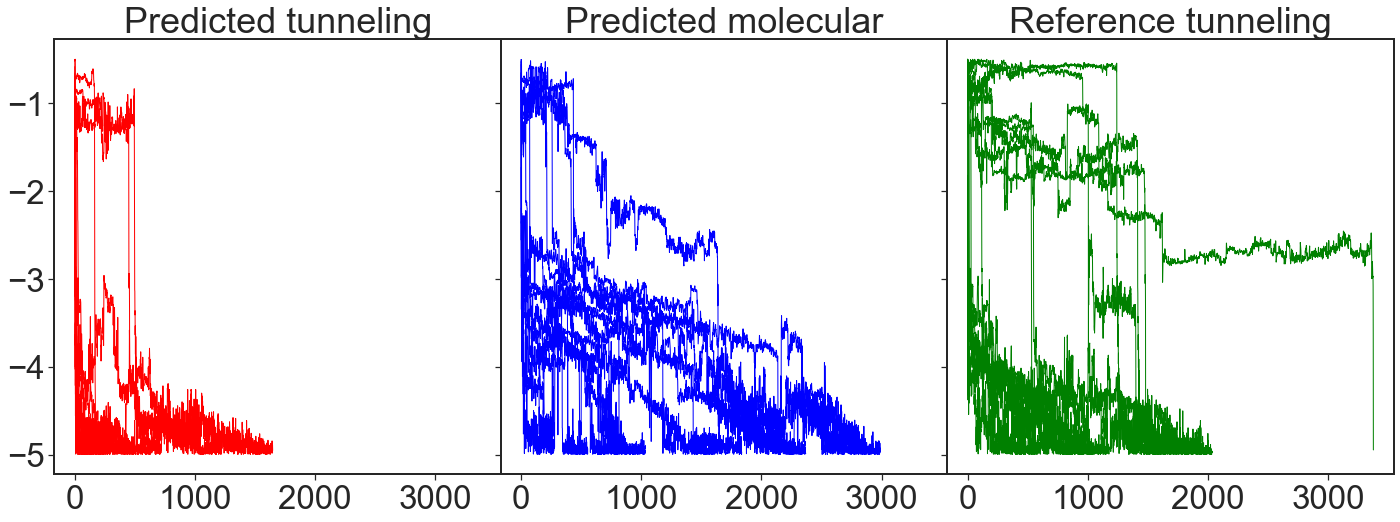

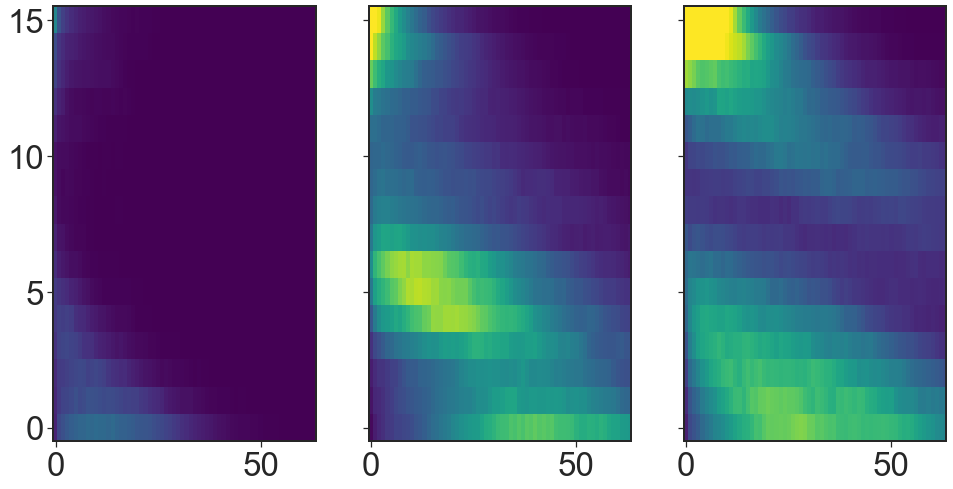

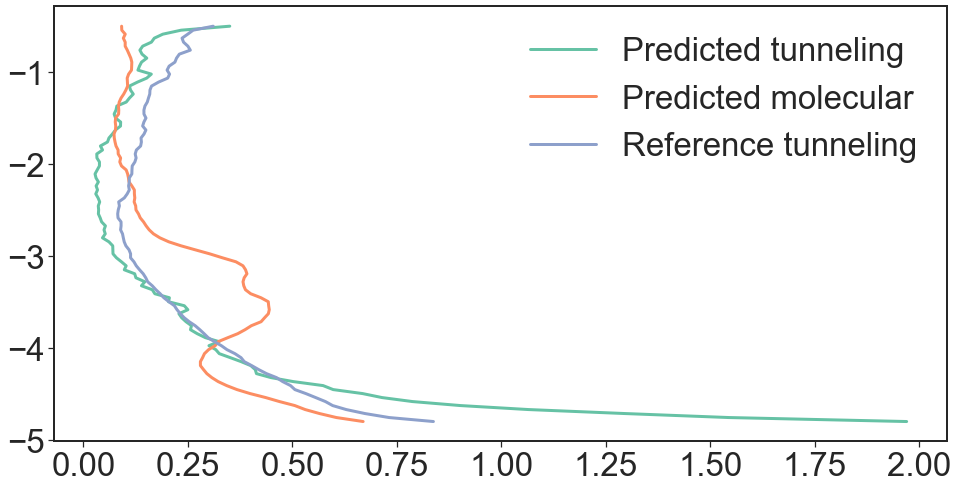

In [73]:
def generate_highres2d(traces, **kwargs):
    highres = []
    for t in tqdm(traces):
        H, *_ = np.histogram2d(t, np.arange(len(t)), **kwargs)
        highres.append(H)
    return np.array(highres)

def generate_1d(traces, **kwargs):
    hist = []
    for t in tqdm(traces):
        H, _ = np.histogram(t, density=True, **kwargs)
        hist.append(H)
    return np.array(hist)


m = p_molecular[used_labels == 1]
p = p_molecular[used_labels == -1]
print(f"Amount predicted molecular: {len(m)}")
print(f"Amount predicted tunneling: {len(p)}")
# fig, ax = plt.subplots()
# ax.plot(hist_molecular[used_labels == 1].sum(axis=0))
# ax.plot(hist_molecular[used_labels == -1].sum(axis=0))
# ax.plot(hist_blanks.sum(axis=0), label="Reference tunneling")
# plt.legend(frameon=False)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 8))
fig.subplots_adjust(wspace=0)
for i in range(16):
    i += 32
    ax[0].plot(m[i], c="r", linewidth=1)
    ax[0].set_title("Predicted tunneling")
    
    ax[1].plot(p[i], c="b", linewidth=1)
    ax[1].set_title("Predicted molecular")

    ax[2].plot(p_blanks[i], c="g", linewidth=1)
    ax[2].set_title("Reference tunneling")


fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 8))
vmax = 2048*8
plot_range = (-4.8, -.5)
# plot_range = (LOW, HIGH)
plot_bins = 100
highres_mol = generate_highres2d(fullwindow_molecular, bins=(16, 64), range=[[*plot_range], [0, 2048]])
full1d_mol = generate_1d(fullwindow_molecular, bins=plot_bins, range=plot_range)
highres_tun = generate_highres2d(fullwindow_blanks, bins=(16, 64), range=[[*plot_range], [0, 2048]])
full1d_tun = generate_1d(fullwindow_blanks, bins=plot_bins, range=plot_range)

ax[0].imshow(
    highres_mol[used_labels == 1].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[1].imshow(
    highres_mol[used_labels == -1].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[2].imshow(
    highres_tun.sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)

fig, ax = plt.subplots(figsize=(16, 8))
x = np.linspace(*plot_range, plot_bins)
ax.plot(full1d_mol[used_labels == 1].sum(axis=0)/len(full1d_mol[used_labels == 1]), x, label="Predicted tunneling")
ax.plot(full1d_mol[used_labels == -1].sum(axis=0)/len(full1d_mol[used_labels == -1]), x, label="Predicted molecular")
ax.plot(full1d_tun.sum(axis=0)/len(full1d_tun), x, label="Reference tunneling")

plt.legend(frameon=False)
plt.show()

In [22]:
from sklearn import metrics
from sklearn.model_selection import KFold
kfold = KFold(n_splits=2, random_state=RNG_STATE, shuffle=True)

# crossvalidate the performance of each model
for model in models:
    avg_acc = []
    for idx, (train_indices, test_indices) in enumerate(kfold.split(features_blanks)):
        train = scaler.fit_transform(features_blanks[train_indices])
        test = scaler.transform(features_blanks[test_indices])

        model.fit(train)

        pred_labels = model.predict(test)

        true_labels = np.ones(len(pred_labels))
        if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
            pred_labels = 1 - pred_labels

        avg_acc.append(
            metrics.accuracy_score(
                true_labels,
                pred_labels,
            )
        )

    print(f"Average accuracy for {model.__class__.__name__}: {np.mean(avg_acc):.4} ± {np.std(avg_acc, ddof=1):.4}")
    print("="*25)

Average accuracy for OneClassSVM: 0.6804 ± 0.0068
Average accuracy for OneClassSVM: 0.9308 ± 0.01983
Average accuracy for OneClassSVM: 0.9523 ± 0.008341
Average accuracy for GMMOutlierDetector: 0.7844 ± 0.01257


## Length distribution

/tmp/ipykernel_25023/2565586844.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_traces)


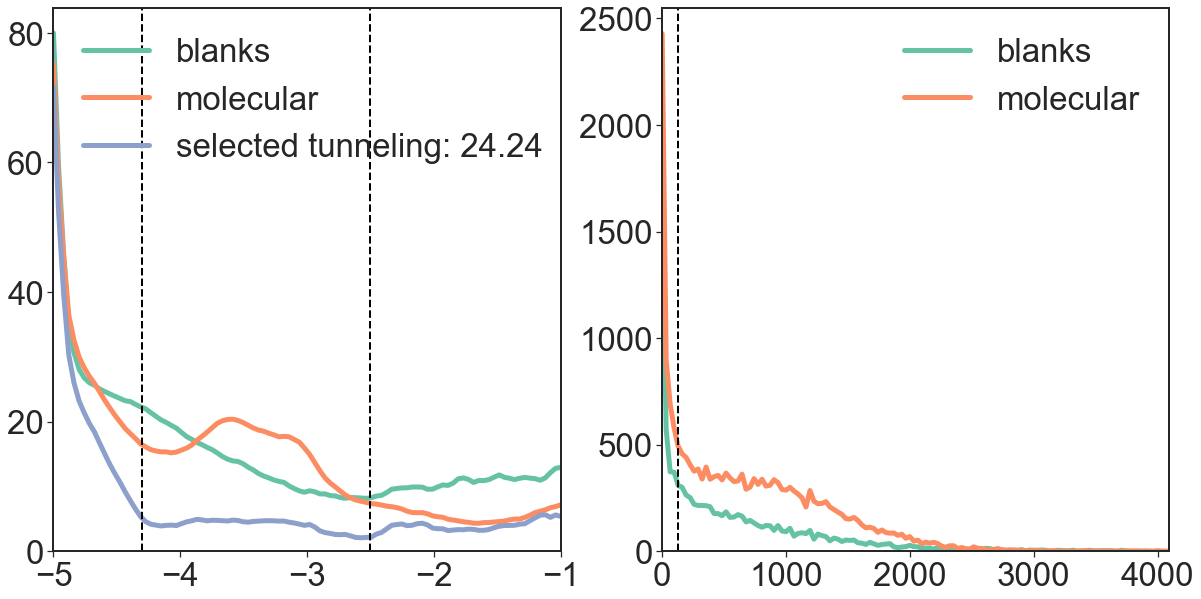

In [49]:
def do_traces(traces, high: float, low: float):
    new_traces = []
    for t in traces:
        t = t[t < high]
        t = t[t > low]
        new_traces.append(t)
    return np.array(new_traces)

histrange = (0, 2048*2)
length_bins = 128

high, low = -2.5, -4.3
np_blanks = do_traces(fullwindow_blanks, high, low)
np_molecular = do_traces(fullwindow_molecular, high, low)
np_blank_hists, np_blank_molecular = [], []
length_labels = []
thresh = 128
for t in np_molecular:
    if len(t) <= thresh or len(t) >= 2048 + 256:
        length_labels.append(1)
    else:
        length_labels.append(-1)
length_labels = np.array(length_labels)

lengths_blanks = np.histogram([len(x) for x in np_blanks], bins=length_bins, range=histrange)[0]
lengths_molecular = np.histogram([len(x) for x in np_molecular], bins=length_bins, range=histrange)[0]

xaxis = np.linspace(pre_info.low, pre_info.high, pre_info.bins)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(xaxis, hist_blanks.sum(axis=0)/len(hist_blanks), label="blanks")
ax[0].plot(xaxis, hist_molecular.sum(axis=0)/len(hist_molecular), label="molecular")
selected_tunneling = hist_molecular[length_labels == 1]
perc = 1 - (len(hist_molecular) - len(selected_tunneling))/len(hist_molecular)
ax[0].plot(xaxis, selected_tunneling.sum(axis=0)/len(selected_tunneling), label=f"selected tunneling: {perc * 100:.4}")
ax[0].axvline(high, linestyle="--", linewidth=2, c="k")
ax[0].axvline(low, linestyle="--", linewidth=2, c="k")
ax[0].set_xlim(pre_info.low, pre_info.high)
ax[0].set_ylim(0)

xaxis = np.linspace(*histrange, length_bins)
ax[1].plot(xaxis, lengths_blanks, label="blanks")
ax[1].plot(xaxis, lengths_molecular, label="molecular")
ax[1].axvline(thresh, linestyle="--", linewidth=2, c="k")
ax[1].set_xlim(histrange)
ax[1].set_ylim(0)

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.show()

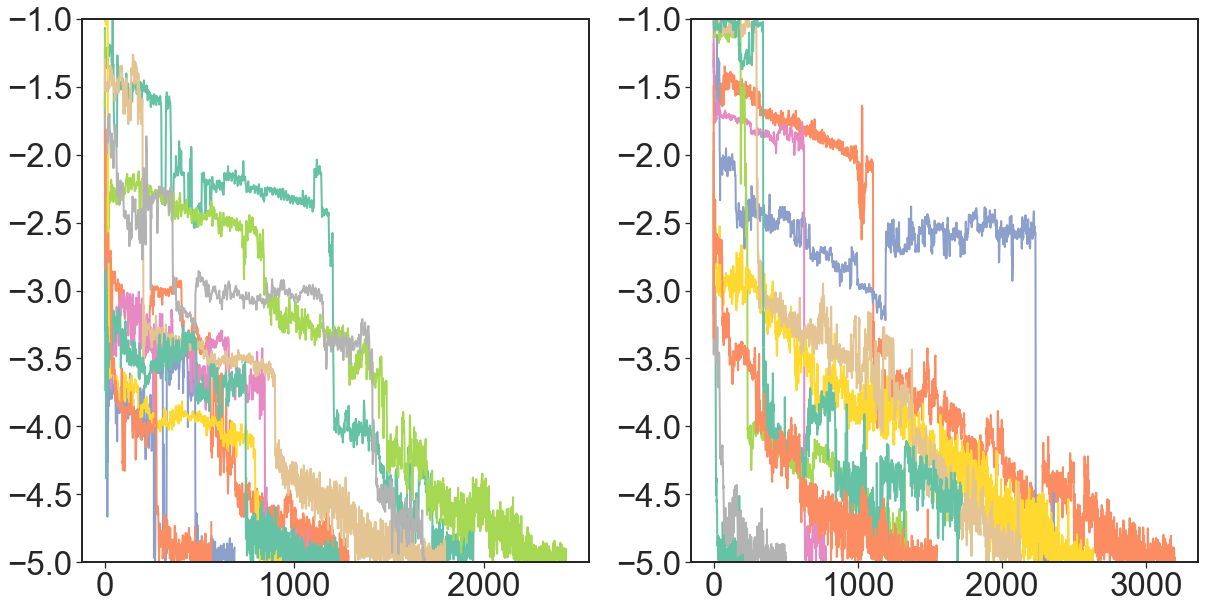

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in p_molecular[length_labels == -1][np.random.randint(low=0, high=len(p_molecular[length_labels == -1]), size=10)]:
    ax[0].plot(t, linewidth=2)
ax[0].set_ylim(pre_info.low, pre_info.high)

for t in p_blanks[np.random.randint(low=0, high=len(p_blanks), size=10)]:
    ax[1].plot(t, linewidth=2)
ax[1].set_ylim(pre_info.low, pre_info.high)
plt.show()

In [ ]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26

ax1_yaxis = np.linspace(pre_info.low, pre_info.high, pre_info.bins)
# ax1_yaxis = np.concatenate(
#     (
#         ax1_yaxis[:start], [np.sum(ax1_yaxis[start:start + gap])/gap], ax1_yaxis[start + gap:]
#     )
# )
max_ax1 = 0
percentages = []
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        # pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not tunneling" if idx == 0 else ""
    )
    pred_tun = hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Tunneling" if idx == 0 else ""
    )
    print(f"Amount predicted tunneling: {len(pred_tun)}")
    percentages.append(1.0 - (len(hist_molecular) - len(pred_tun))/len(hist_molecular))

    ax[idx, 0].plot(
        hist_blanks.sum(axis=0)/len(hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference tunneling" if idx == 0 else "_",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.low, pre_info.high], [0, 2048]]
        )
        hist_2d += H

    im = ax[idx, 1].imshow(
        hist_2d,
        vmin=0,
        vmax=256,
        origin="lower",
        cmap="viridis",
        extent=[0, 2048, pre_info.low, pre_info.high],
        aspect="auto",
    )

    if np.max(pred_mol.sum(axis=0)/len(pred_mol)) > max_ax1:
        max_ax1 = np.max(pred_mol.sum(axis=0)/len(pred_mol))
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.low, pre_info.high)

text_height = -1.7
for idx, p in enumerate(percentages):
    ax[idx, 0].text(max_ax1 - max_ax1*0.0, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(
        1024 + 512 + 256, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    ax[idx, 1].text(1024 + 512, text_height - .6, f"%T = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")

    ax[idx, 0].set_xlim(0, max_ax1 + max_ax1*0.15)
    if idx == 0:
        ax[idx, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(-0.1, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE // 2)

ax[-1, 0].set_xlabel("Normalized counts")
ax[-1, 1].set_xlabel("# data point")
fig.text(0.04, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical")
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
# plt.savefig("./greta_visual_perf_dl_24epochs_small.pdf")
plt.show()

## Using DROCC

In [205]:
import drocc
from drocc import DROCCTrainer
import importlib
importlib.reload(drocc)
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [322]:
def adjust_learning_rate(epoch, total_epochs, only_ce_epochs, learning_rate, optimizer):
        """Adjust learning rate during training.
        Parameters
        ----------
        epoch: Current training epoch.
        total_epochs: Total number of epochs for training.
        only_ce_epochs: Number of epochs for initial pretraining.
        learning_rate: Initial learning rate for training.
        """
        #We dont want to consider the only ce 
        #based epochs for the lr scheduler
        epoch = epoch - only_ce_epochs
        drocc_epochs = total_epochs - only_ce_epochs
        # lr = learning_rate
        if epoch <= drocc_epochs:
            lr = learning_rate * 0.001
        if epoch <= 0.90 * drocc_epochs:
            lr = learning_rate * 0.01  
        if epoch <= 0.60 * drocc_epochs:
            lr = learning_rate * 0.1  
        if epoch <= 0.30 * drocc_epochs:
            lr = learning_rate    
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

class MLP(nn.Module):
    """
    Multi-layer perceptron with two hidden layer.
    """
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        num_hidden_nodes: int,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_hidden_nodes = num_hidden_nodes
        activ = nn.ReLU(True)
        self.feature_extractor = nn.Sequential(
            OrderedDict(
                [
                    ('fc1', nn.Linear(self.input_dim, self.num_hidden_nodes)),
                    ('relu1', activ),
                    ('fc2', nn.Linear(self.num_hidden_nodes, self.num_hidden_nodes)),
                    ('relu2', activ),
                ]
            )
        )
        self.size_final = self.num_hidden_nodes

        self.classifier = nn.Sequential(
            OrderedDict(
                [
                    ('fc1', nn.Linear(self.size_final, self.num_classes))
                ]
            )
        )

    def forward(self, inp):
        features = self.feature_extractor(inp)
        logits = self.classifier(features.view(-1, self.size_final))
        return logits

class CNN(nn.Module):
    """
    Simple convolutional neural network
    """
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2),

            # nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        num_classes = 1
        self.linear_layers = nn.Sequential(
            nn.Linear(144, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)


class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(8, 8, downsample=False),
            resblock(8, 8, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(8, 16, downsample=True),
            resblock(16, 16, downsample=False)
        )

        # self.layer3 = nn.Sequential(
        #     resblock(32, 64, downsample=True),
        #     resblock(64, 64, downsample=False),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )


        # self.layer4 = nn.Sequential(
        #     resblock(64, 512, downsample=True),
        #     resblock(512, 512, downsample=False)
        # )

        # self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(1024, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        # input = self.layer3(input)
        # input = self.layer4(input)
        input = input.view(input.size(0), -1)

        # input = self.gap(input)
        # input = torch.flatten(input)
        input = self.fc(input)

        return input

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return torch.from_numpy(self.data[idx]), (self.labels[idx]), torch.tensor([0])

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) + 1e-2

def load_data(x_train, y_train, x_test):
    ## preprocessing 
    mean = np.mean(x_train, 0)
    std = np.std(x_train, 0)
    # x_train = (x_train - mean)/ (std + 1e-4)
    x_train = normalize(x_train)
    num_features = x_train.shape[1]
    # x_test = (x_test - mean)/(std + 1e-4)
    x_test = normalize(x_test)

    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print("Train Samples: ", train_samples)
    print("Test Samples: ", test_samples)

    # x_train = x_train.reshape(x_train.shape[0], 1, BINS_2D[0], BINS_2D[1])
    # x_test = x_test.reshape(x_test.shape[0], 1, BINS_2D[0], BINS_2D[1])
    
    return CustomDataset(x_train, y_train), CustomDataset(x_test, np.ones(len(x_test))), num_features

In [326]:
lr = 1e-3
epochs = 16
only_ce_epochs = 2
ascent_step_size = 0.001

model = MLP(input_dim=BINS_2D[0]*BINS_2D[1] + ef_blanks.shape[1], num_classes=1, num_hidden_nodes=256)
# model = MLP(input_dim=BINS, num_classes=1, num_hidden_nodes=128)
# model = CNN()
# model = ResNet18(in_channels=1, resblock=ResBlock)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lamda = 1
radius = .8
gamma = 1.
device = "cpu"
batch_size = 256

drocc_trainer = DROCCTrainer(
    model=model,
    optimizer=optimizer,
    lamda=lamda,
    radius=radius,
    gamma=gamma,
    device=device,
)

In [327]:
drocc_train_amount = 1024*4
drocc_test_amount = 1024*2
x_train = features_blanks[:drocc_train_amount]
y_train = np.ones(len(x_train))
x_test = features_molecular[:drocc_test_amount]

train_dataset, test_dataset, num_features = load_data(x_train, y_train, x_test)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

Train Samples:  4096
Test Samples:  2048


In [328]:
drocc_trainer.train(
    train_loader,
    learning_rate=lr,
    lr_scheduler=adjust_learning_rate,
    total_epochs=epochs,
    ascent_step_size=ascent_step_size,
    ascent_num_steps=32,
    only_ce_epochs=only_ce_epochs,
)

Epoch: 0, CE Loss: 0.29485028982162476, AdvLoss: 0.0
Epoch: 1, CE Loss: 0.00045045599108561873, AdvLoss: 0.0
Epoch: 2, CE Loss: 0.10065461695194244, AdvLoss: 6.381704330444336
Epoch: 3, CE Loss: 0.6555342674255371, AdvLoss: 0.7375661730766296
Epoch: 4, CE Loss: 0.700473964214325, AdvLoss: 0.6860470175743103
Epoch: 5, CE Loss: 0.6998525857925415, AdvLoss: 0.6864043474197388
Epoch: 6, CE Loss: 0.6966938972473145, AdvLoss: 0.6893930435180664
Epoch: 7, CE Loss: 0.6950302124023438, AdvLoss: 0.6909517049789429
Epoch: 8, CE Loss: 0.6949082016944885, AdvLoss: 0.6910451054573059
Epoch: 9, CE Loss: 0.6947273015975952, AdvLoss: 0.691205620765686
Epoch: 10, CE Loss: 0.6945929527282715, AdvLoss: 0.6913504600524902
Epoch: 11, CE Loss: 0.694536566734314, AdvLoss: 0.6913617253303528
Epoch: 12, CE Loss: 0.6945188641548157, AdvLoss: 0.6913909912109375
Epoch: 13, CE Loss: 0.6945021152496338, AdvLoss: 0.6913880109786987
Epoch: 14, CE Loss: 0.6944841742515564, AdvLoss: 0.6913970708847046
Epoch: 15, CE Loss

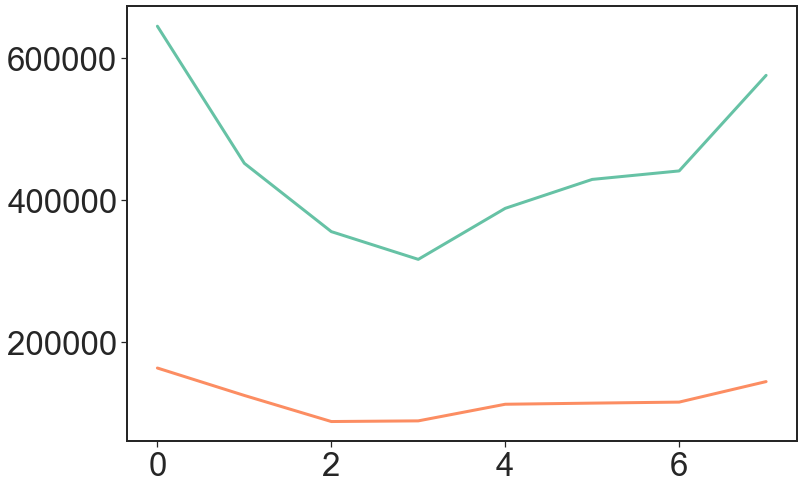

In [329]:
from numpy import percentile


model.eval()
contamination = 0.2
preds = []
for batch, target, _ in train_loader:
    data, target = batch.to(device), target.to(device)
    # Data Processing
    data = data.to(torch.float)
    target = target.to(torch.float)
    target = torch.squeeze(target)

    logits = model(data)
    logits = torch.squeeze(logits, dim=1)

    preds.append(logits.detach().numpy())
preds = np.concatenate(preds)
threshold_ = percentile(preds, 100 * (1 - contamination))
labels = (preds > threshold_).astype('int').ravel()

plt.plot(hist_blanks[:drocc_train_amount][labels == 0].sum(axis=0))
plt.plot(hist_blanks[:drocc_train_amount][labels == 1].sum(axis=0))
plt.show()

Predicted tunneling: 460
Predicted molecular: 1588


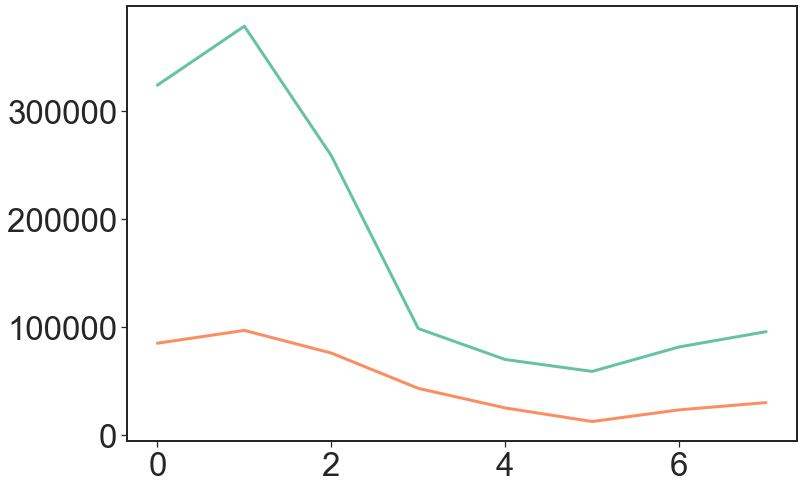

In [330]:
model.eval()
preds = []
for batch, target, _ in test_loader:
    data, target = batch.to(device), target.to(device)
    # Data Processing
    data = data.to(torch.float)
    target = target.to(torch.float)
    target = torch.squeeze(target)

    logits = model(data)
    logits = torch.squeeze(logits, dim=1)

    preds.append(logits.detach().numpy())
preds = np.concatenate(preds)
labels = (preds > threshold_).astype('int').ravel()

plt.plot(hist_molecular[:drocc_test_amount][labels == 0].sum(axis=0))
plt.plot(hist_molecular[:drocc_test_amount][labels == 1].sum(axis=0))

print(f"Predicted tunneling: {len(labels[labels == 1])}")
print(f"Predicted molecular: {len(labels[labels == 0])}")
plt.show()

Amount predicted molecular: 460
Amount predicted tunneling: 1588


100%|██████████| 4096/4096 [00:01<00:00, 3553.47it/s]


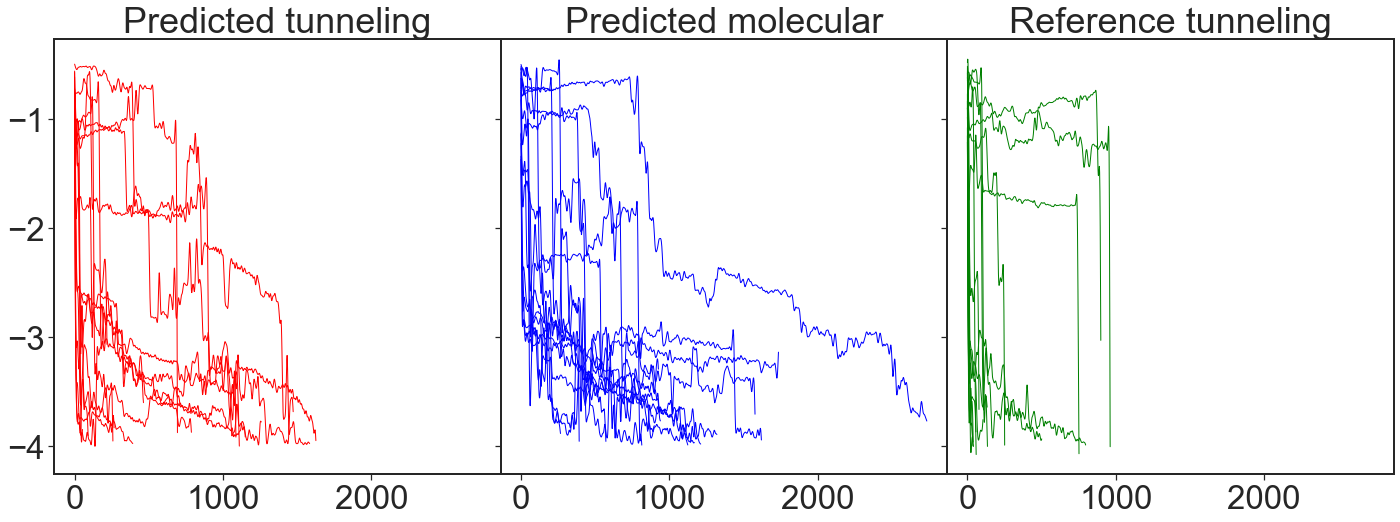

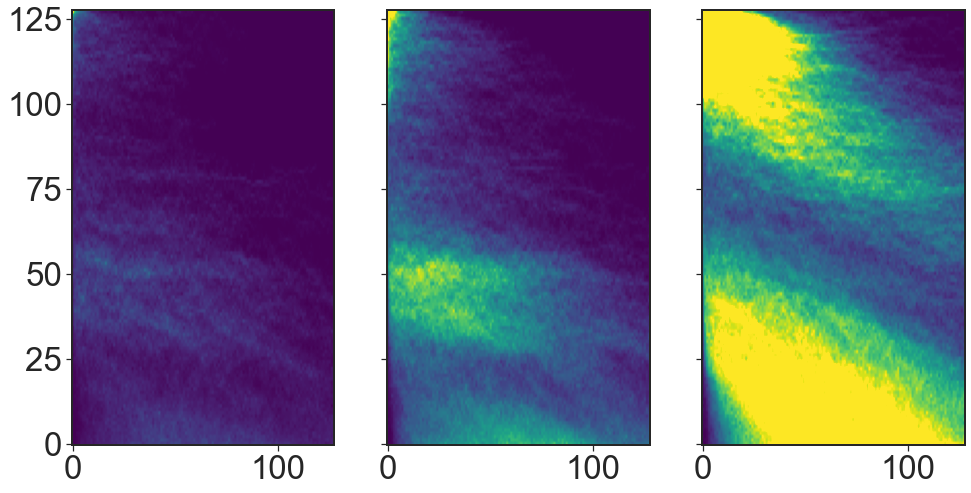

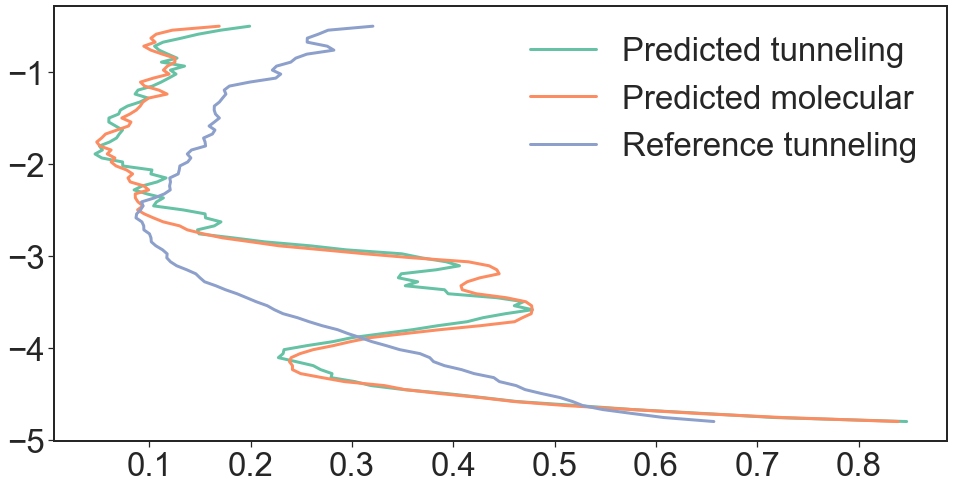

In [331]:
def generate_highres2d(traces, **kwargs):
    highres = []
    for t in tqdm(traces):
        H, *_ = np.histogram2d(t, np.arange(len(t)), **kwargs)
        highres.append(H)
    return np.array(highres)

def generate_1d(traces, **kwargs):
    hist = []
    for t in tqdm(traces):
        H, _ = np.histogram(t, density=True, **kwargs)
        hist.append(H)
    return np.array(hist)


m = p_molecular[:drocc_test_amount][labels == 1]
p = p_molecular[:drocc_test_amount][labels == 0]
print(f"Amount predicted molecular: {len(m)}")
print(f"Amount predicted tunneling: {len(p)}")
# fig, ax = plt.subplots()
# ax.plot(hist_molecular[used_labels == 1].sum(axis=0))
# ax.plot(hist_molecular[used_labels == -1].sum(axis=0))
# ax.plot(hist_blanks.sum(axis=0), label="Reference tunneling")
# plt.legend(frameon=False)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 8))
fig.subplots_adjust(wspace=0)
for i in range(16):
    i += 0
    ax[0].plot(m[i], c="r", linewidth=1)
    ax[0].set_title("Predicted tunneling")
    
    ax[1].plot(p[i], c="b", linewidth=1)
    ax[1].set_title("Predicted molecular")

    ax[2].plot(p_blanks[i], c="g", linewidth=1)
    ax[2].set_title("Reference tunneling")


fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 8))
vmax = 512
plot_range = (-4.8, -.5)
# plot_range = (LOW, HIGH)
plot_bins = 100
highres_mol = generate_highres2d(fullwindow_molecular[:drocc_test_amount], bins=(128, 128), range=[[*plot_range], [0, 2048]])
full1d_mol = generate_1d(fullwindow_molecular[:drocc_test_amount], bins=plot_bins, range=plot_range)
highres_tun = generate_highres2d(fullwindow_blanks[:drocc_train_amount], bins=(128, 128), range=[[*plot_range], [0, 2048]])
full1d_tun = generate_1d(fullwindow_blanks[:drocc_train_amount], bins=plot_bins, range=plot_range)

ax[0].imshow(
    highres_mol[labels == 1].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[1].imshow(
    highres_mol[labels == 0].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[2].imshow(
    highres_tun.sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)

fig, ax = plt.subplots(figsize=(16, 8))
x = np.linspace(*plot_range, plot_bins)
ax.plot(full1d_mol[labels == 1].sum(axis=0)/len(full1d_mol[labels == 1]), x, label="Predicted tunneling")
ax.plot(full1d_mol[labels == 0].sum(axis=0)/len(full1d_mol[labels == 0]), x, label="Predicted molecular")
ax.plot(full1d_tun.sum(axis=0)/len(full1d_tun), x, label="Reference tunneling")

plt.legend(frameon=False)
plt.show()

## Clustering result

In [19]:
cluster_labels = np.load("./cluster_labels_data_5.npy")
cluster_filtered_labels = np.load("./cluster_labels_filtered_data_5.npy")
oc_labels = np.load("./traditional_oc_labels_halftunneling.npy")

In [20]:
def plot_cluster(sample_hists, blank_hists, labels, axes):
    max_ax1 = 0
    for idx, (m, ax) in enumerate(
        tqdm(
            zip(
                np.arange(len(labels)), axes.ravel()
            ),
            total=len(axes.ravel())
        )
    ):      
    
        ax.plot(
            ax1_yaxis,
            blank_hists.sum(axis=0),
            c=c[0],
            linestyle="--",
            label="Ref. blanks" if idx == 0 else "",
            alpha=0.8,
        )
        ax.plot(
            ax1_yaxis,
            sample_hists.sum(axis=0),
            c="k",
            linestyle="--",
            label="Ref. samples" if idx == 0 else "",
            alpha=0.8,
        )

        for label in np.unique(labels[m]):
            pred = sample_hists[labels[m] == label]
            ax.plot(
                ax1_yaxis,
                pred.sum(axis=0),
                label=f"{label + 1}" if idx == 0 else "",
            )
            # print(f"Amount of traces in {label + 1}: {len(pred)}")

            if np.max(pred.sum(axis=0)) > max_ax1:
                max_ax1 = np.max(pred.sum(axis=0))


        if np.max(sample_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(sample_hists.sum(axis=0))

        if np.max(blank_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(blank_hists.sum(axis=0))

        ax.set_xlim(pre_info.plot_low, pre_info.plot_high)

100%|██████████| 5/5 [00:00<00:00, 39.16it/s]


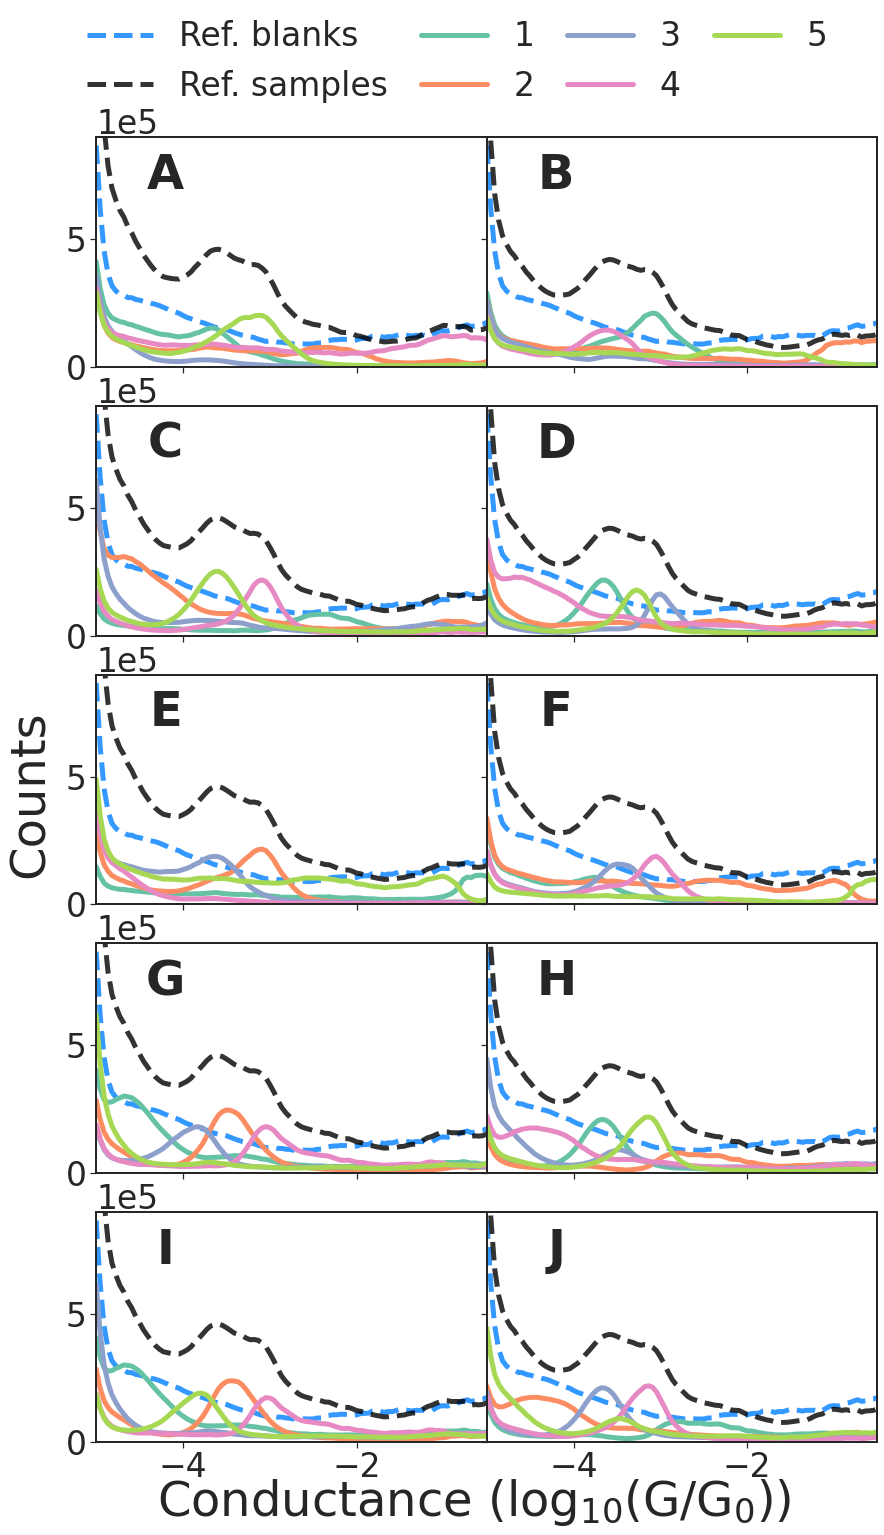

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(14, 24))
fig.subplots_adjust(hspace=0.17, wspace=0.0)
ax1_yaxis = np.linspace(
    pre_info.plot_low, pre_info.plot_high, plot_hist_molecular.shape[1]
)
plot_cluster(plot_hist_molecular, plot_hist_blanks, cluster_labels, axes[:, 0])
plot_cluster(
    plot_hist_molecular[oc_labels[5] == -1],
    plot_hist_blanks,
    cluster_filtered_labels,
    axes[:, 1],
)

for idx, ax in enumerate(axes.ravel()):
    ax.text(
        -4.2,
        7.5e5,
        ALPHABET[idx],
        va="center",
        ha="center",
        weight="bold",
        fontsize=FONTSIZE
    )
    ax.set_ylim(0, 9e5)
    ax.ticklabel_format(axis="y", scilimits=[-5, 4])

fig.text(
    0.06,
    0.5,
    "Counts",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=FONTSIZE,
)
fig.text(0.5, 0.09, CONDUCTANCE_LABEL, va="center", ha="center", fontsize=FONTSIZE)
axes.ravel()[0].legend(
    frameon=False,
    loc="lower left",
    bbox_to_anchor=(-0.1, 1.02, 1, 0),
    ncol=4,
    columnspacing=1.0,
)
plt.savefig("./clustering_result.pdf")
plt.show()